In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn import metrics
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader,TensorDataset, Dataset
from plotly import graph_objects as go
import math
import os
import torch.nn.functional as F
import shutil
import xgboost as xgb
import random
from scipy import stats

d:\Python\anaconda3\envs\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def sliding_window(data, sw_width, in_start=0):
    #该函数实现窗口宽度为sw_width、滑动步长为1的滑动窗口截取序列数据
    X = []
    data = np.array(data, type(float))
    for _ in range(data.shape[0]):
        in_end = in_start + sw_width
        if (in_end>data.shape[0]):
            break
        else:
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end, :]
            X.append(train_seq)
            in_start += 1
    return np.array(X)

In [5]:
# 定义一个简单的ANN模型
class ann_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ann_net, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [6]:
class lstm_net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(lstm_net, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,  
            hidden_size=hidden_dim,  
            num_layers=layers, 
            bias=True,  
            batch_first=True,
        )

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),
            nn.ELU(inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(inplace=True),
            nn.Linear(hidden_dim//2, 1),
        )

    def forward(self,x):
        r_out,(h_t,c_t) = self.lstm(x)
        batch, time_step, hidden_size = r_out.shape
        out = r_out[:, -1, :].view(batch, -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
class Data_set(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, id):
        data = (self.x[id],
                self.y[id])
        return data

    def __len__(self):
        return len(self.y)

In [34]:
# if __name__ == '__main__':
#     # parameters
#     TIME_STEP = 31
#     BATCH_SIZE = 32 # 128
#     epoches = 200
    
#     #设置随机种子
#     seed = random.randint(0, 4294967295)
#     # seed = 166143082
#     # print('随机种子：',seed)

#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     torch.set_default_tensor_type(torch.FloatTensor)

#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)

#     # 读取数据
#     data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997_PQ.xlsx')

#     # 1977-1997 (train: 1977-1986, test: 1987-1990)
#     data = np.array(data)
#     data = data[:,3:]
#     data_train = data[:3652,:]
#     data_test = data[3652:,:]
#     # p 1: fine_tune: 1987-1989 
#     data_p1 = data[3652:,:]
#     data_p1_train = data_p1[:1096,:]
#     data_p1_test = data_p1[1096:,:]
#     # p 2: fine_tune = 1990-1992
#     data_p2 = data[4748:,:]
#     data_p2_train = data_p2[:1096,:]
#     data_p2_test = data_p2[1096:,:]
#     # p 3 :fine_tune = 1993-1995
#     data_p3 = data[5844:,:]
#     data_p3_train = data_p3[:1095,:]
#     data_p3_test = data_p3[1095:,:]
#     # p 4 :fine_tune = 1995-1996_6
#     data_p4 = data[6574:,:]
#     data_p4_train = data_p4[:547,:]
#     data_p4_test = data_p4[547:,:]
#     #闰年 1980，1984，1988，1992，1996
#     # 3652+365+366+365+365+365+366+365+365+365+366
#     # setting
#     train_set = data[:3652,:]
#     test_set = data[3652:3652+365,:]
#     # train_set = data_train
#     # test_set = data_test


In [46]:
# if __name__ == '__main__': 
#  # lstm
#     loader_lstm = DataLoader(Data_set(train_x, train_y), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    
#     model_lstm = lstm_net(input_dim=8, hidden_dim=64, output_dim=1, layers=3)
#     # # model.load_state_dict(torch.load(r'E:\work\Basin\Tangnaihai\气象站07-14\lstm\_epoch_351.pkl')["model_state_dict"])
#     optimizer = optim.Adam(model_lstm.parameters(),lr = 3e-4)
#     criterion = nn.MSELoss()

#     model_lstm.train()
#     lowest_loss = 1000000
#     for epoch in range(epoches):
#         for data in loader_lstm:
#             x, y = data
#             # print(x.shape)
#             # print(y.shape)
#             x, y = torch.tensor(x), torch.tensor(y)
#             optimizer.zero_grad()
#             pred = model_lstm.forward(x).squeeze()
#             loss = criterion(pred, y.squeeze())
#             loss.backward(retain_graph=True)
#             optimizer.step()
    
#         checkpoint = {"model_state_dict": model_lstm.state_dict(),
#                   "optimizer_state_dic": optimizer.state_dict(),
#                   "loss": loss,
#                   "epoch": epoch}
#         if loss.item() < lowest_loss:
#             lowest_loss = loss.item()
#             save_model_path = r'e:\work\data-stream\research\myModel\compare_model\lstm'
#             # if os.path.exists(save_model_path):
#             #     shutil.rmtree(save_model_path)
#             # os.makedirs(save_model_path)
#             path_checkpoint = save_model_path+'/'+'lstm_77-95_epoch_{}.pkl'.format(epoch)
#             # best_checkpoint = save_model_path+'/'+'lstm_77-92_epoch_{}.pkl'.format(epoch)

#             torch.save(checkpoint, path_checkpoint)


#         print('Epoch:', '%04d' % (epoch), 'loss:', loss.item())


In [36]:
# if __name__ == '__main__': 
#  # ann
#     train_x = train_x.reshape(train_x.shape[0],-1)
#     loader_ann = DataLoader(Data_set(torch.tensor(train_x), torch.tensor(train_y)), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    
#     model_ann = ann_net(input_dim=8*TIME_STEP, hidden_dim=64, output_dim=1)
#     # # model.load_state_dict(torch.load(r'E:\work\Basin\Tangnaihai\气象站07-14\lstm\_epoch_351.pkl')["model_state_dict"])
#     optimizer = optim.Adam(model_ann.parameters(),lr = 3e-2)
#     criterion = nn.MSELoss()

#     model_ann.train()
#     lowest_loss = 1000000
#     for epoch in range(epoches):
#         for data in loader_ann:
#             x, y = data
#             # x, y = torch.tensor(x), torch.tensor(y)
#             optimizer.zero_grad()
#             pred = model_ann.forward(x).squeeze()
#             loss = criterion(pred, y.squeeze())
#             loss.backward(retain_graph=True)
#             optimizer.step()
    
#         checkpoint = {"model_state_dict": model_ann.state_dict(),
#                   "optimizer_state_dic": optimizer.state_dict(),
#                   "loss": loss,
#                   "epoch": epoch}
#         if loss.item() < lowest_loss:
#             lowest_loss = loss.item()
#             save_model_path = r'e:\work\data-stream\research\myModel\compare_model\ann'
#             # if os.path.exists(save_model_path):
#             #     shutil.rmtree(save_model_path)
#             # os.makedirs(save_model_path)
#             path_checkpoint = save_model_path+'/'+'ann_77-96-6_epoch_{}.pkl'.format(epoch)
#             torch.save(checkpoint, path_checkpoint)

#         print('Epoch:', '%04d' % (epoch), 'loss:', loss.item())

In [7]:
# xgboost
from sklearn.svm import SVR
if __name__ == '__main__': 

    # parameters
    TIME_STEP = 31
    BATCH_SIZE = 32 # 128
    epoches = 200
    
    #设置随机种子
    seed = random.randint(0, 4294967295)
    # seed = 166143082
    # print('随机种子：',seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.set_default_tensor_type(torch.FloatTensor)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    # 读取数据
    data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997_PQ.xlsx')

    # 1977-1997 (train: 1977-1986, test: 1987-1990)
    data = np.array(data)
    data = data[:,3:]
    # data_train = data[:3652,:]
    # data_test = data[3652:,:]
    # # p 1: fine_tune: 1987-1989 
    # data_p1 = data[3652:,:]
    # data_p1_train = data_p1[:1096,:]
    # data_p1_test = data_p1[1096:,:]
    # # p 2: fine_tune = 1990-1992
    # data_p2 = data[4748:,:]
    # data_p2_train = data_p2[:1096,:]
    # data_p2_test = data_p2[1096:,:]
    # # p 3 :fine_tune = 1993-1995
    # data_p3 = data[5844:,:]
    # data_p3_train = data_p3[:1095,:]
    # data_p3_test = data_p3[1095:,:]
    # # p 4 :fine_tune = 1995-1996_6
    # data_p4 = data[6574:,:]
    # data_p4_train = data_p4[:547,:]
    # data_p4_test = data_p4[547:,:]
    #闰年 1980，1984，1988，1992，1996
    # 3652+365+366+365+365+365+366+365+365+365+366+365
    # setting
    train_set = data[:3652+365+366+365,:]
    test_set = data[3652+365+366:3652+365+366+365,:]
    # train_set = data_train
    # test_set = data_test
#---------------------------------------------------------------------------------
    train_x = sliding_window((train_set[:, 0:-1]), TIME_STEP).astype(np.float32)
    # train_y = sliding_window((train_set[:, -1:]), TIME_STEP).astype(np.float32)
    train_y = sliding_window((train_set[:, -1:]), TIME_STEP)[:, -1, :].astype(np.float32)

    train_x = train_x.reshape(train_x.shape[0],-1)
    train_y = train_y.squeeze()

    test_x = sliding_window((test_set[:, 0:-1]), TIME_STEP).astype(np.float32)
    test_y = sliding_window((test_set[:, -1:]), TIME_STEP)[:, -1, :].astype(np.float32)

    test_x = test_x.reshape(test_x.shape[0],-1)
    # test_x = test_x.reshape(test_x.shape[0],-1)
    test_y = test_y.squeeze()

    model_num = 4
    prediction = np.zeros((model_num,3,test_y.shape[0]))
    print(prediction.shape)

    for seed_num in range(0,model_num):
        seed_temp = random.randint(0, 4294967295)
        # 定义XGBoost参数
        params = {
            'objective': 'reg:squarederror',
            'max_depth': 5,
            'learning_rate': 0.01,
            'n_estimators': 200,
            'seed': seed_temp
        }
        model_xgboost = xgb.XGBRegressor(**params)
        model_xgboost.fit(train_x, train_y)
        # rf
        model_rf = RandomForestRegressor(random_state=seed_temp)  # 这里使用了默认的参数设置
        model_rf.fit(train_x, train_y)  # 进行模型的训练
        model_svr = SVR(kernel='linear')
        model_svr.fit(train_x, train_y)

        pred_xgboost = model_xgboost.predict(test_x)
        pred_rf = model_rf.predict(test_x)
        pred_svr = model_svr.predict(test_x)

        pred_xgboost = pred_xgboost.reshape(-1,1)
        pred_rf = pred_rf.reshape(-1,1)
        pred_svr = pred_svr.reshape(-1,1)
        prediction[seed_num,0:] = pred_xgboost.squeeze()
        prediction[seed_num,1,:] = pred_rf.squeeze()
        prediction[seed_num,2,:] = pred_svr.squeeze()
  
    print(prediction.shape)
    # model_xgboost.fit(train_x, train_y)
    # pred_y = model_xgboost.predict(test_x)



# # rf
    # model_rf = RandomForestRegressor(random_state=seed)  # 这里使用了默认的参数设置
    # model_rf.fit(train_x, train_y)  # 进行模型的训练
#     # prediction = model_rf.predict(test_x)

# svr
    # model_svr = SVR(kernel='linear')
    # for ck in range(200,1000):
    # clf = SVR( kernel ='rbf', degree = 3,
    #     gamma ='auto',coef0 = 0.0,tol = 0.001,
    #     C = 215,epsilon = 0.0001,shrinking = True,
    #     cache_size = 200,verbose = False,max_iter = -1)
    # model_svr.fit(train_x, train_y)
    # y_pred = model_svr.predict(test_x)

(4, 3, 335)
(4, 3, 335)


In [78]:
# test
# if __name__ == '__main__': 
#     test_x = sliding_window((test_set[:, 0:-1]), TIME_STEP).astype(np.float32)
#     test_y = sliding_window((test_set[:, -1:]), TIME_STEP)[:, -1, :].astype(np.float32)

#     model_lstm_test = lstm_net(input_dim=8, hidden_dim=64, output_dim=1, layers=3)
#     model_lstm_test.load_state_dict(torch.load(r'E:\work\data-stream\research\myModel\compare_model\lstm\lstm_77-96-6_epoch_183.pkl')['model_state_dict'])
#     model_lstm_test.eval()
#     with torch.no_grad():
#         # test_x = torch.tensor(test_x)
#         pred_lstm = model_lstm_test.forward(torch.tensor(test_x)).squeeze()
    
#     test_x = test_x.reshape(test_x.shape[0],-1)
#     model_ann_test = ann_net(input_dim=8*TIME_STEP, hidden_dim=64, output_dim=1)
#     model_ann_test.load_state_dict(torch.load(r'E:\work\data-stream\research\myModel\compare_model\ann\ann_77-96-6_epoch_153.pkl')['model_state_dict'])
#     model_ann_test.eval()
#     with torch.no_grad():
#         # test_x = torch.tensor(test_x)
#         pred_ann = model_ann_test.forward(torch.tensor(test_x)).squeeze()


#     test_x = test_x.reshape(test_x.shape[0],-1)
#     test_y = test_y.squeeze()

#     pred_xgboost = model_xgboost.predict(test_x)
#     pred_xgboost = (model_xgboost_1.predict(test_x) + model_xgboost_2.predict(test_x) + model_xgboost_3.predict(test_x) + model_xgboost_4.predict(test_x) + model_xgboost_5.predict(test_x))/5
#     pred_rf = model_rf.predict(test_x)
#     pred_svr = model_svr.predict(test_x)

R2_xgboost: 0.763207561223697
R2_rf: 0.9535268050015874
R2_svr: 0.7460390756606914
       obs     xgboost        rf         svr
0    142.0  210.534531  175.7775  168.897320
1    153.0  224.957458  181.0700  156.176170
2    154.0  220.941177  188.5850  180.562662
3    150.0  231.057953  191.2050  180.109470
4    154.0  233.869781  188.9600  188.006155
..     ...         ...       ...         ...
330  285.0  331.195770  281.4850  244.756111
331  274.0  290.207245  258.2000  209.523406
332  270.0  302.219818  264.5525  221.233243
333  268.0  304.208191  261.5250  237.854816
334  269.0  302.545929  251.2100  217.627583

[335 rows x 4 columns]


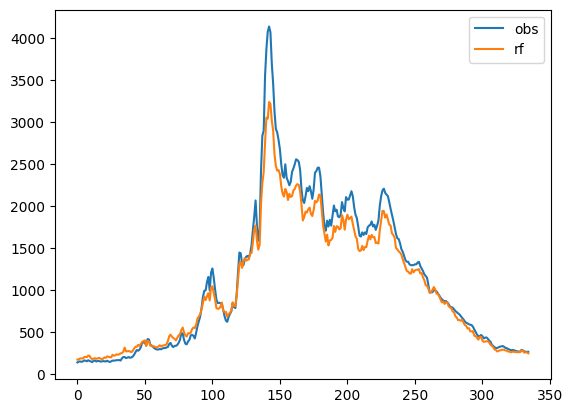

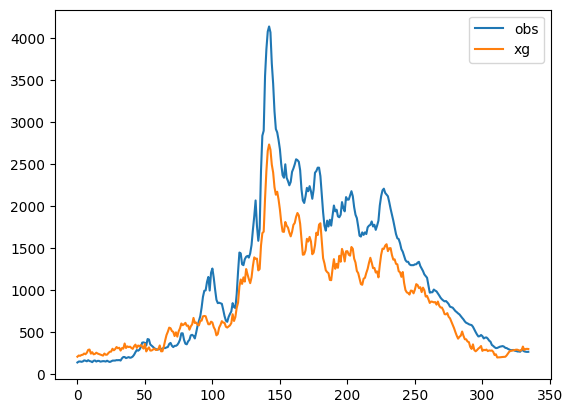

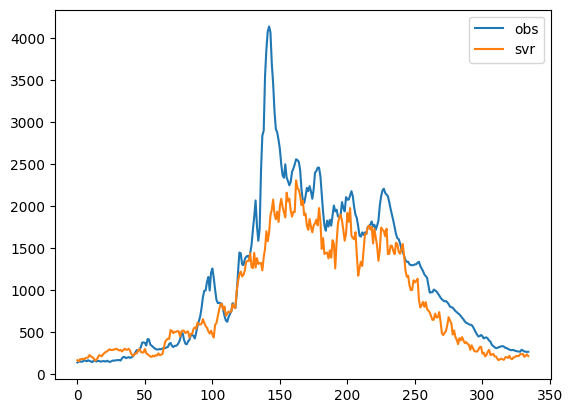

In [8]:
# 将tensor转换为numpy
# pred_lstm = pred_lstm.numpy()
# pred_ann = pred_ann.numpy()
# 将预测值整合并保存为excel
# pred_lstm = pred_lstm.reshape(-1,1)
# pred_ann = pred_ann.reshape(-1,1)
# pred_xgboost = pred_xgboost.reshape(-1,1)
# pred_rf = pred_rf.reshape(-1,1)
# pred_svr = pred_svr.reshape(-1,1)


pred_xgboost = np.mean(prediction[:,0,:],axis=0).reshape(-1,1)
pred_rf = np.mean(prediction[:,1,:],axis=0).reshape(-1,1)
pred_svr = np.mean(prediction[:,2,:],axis=0).reshape(-1,1)
test_y = test_y.reshape(-1,1)


# R2_lstm = metrics.r2_score(test_y, pred_lstm)
# R2_ann = metrics.r2_score(test_y, pred_ann)
R2_xgboost = metrics.r2_score(test_y, pred_xgboost)
R2_rf = metrics.r2_score(test_y, pred_rf)
R2_svr = metrics.r2_score(test_y, pred_svr)

# print('R2_lstm:',R2_lstm)
# print('R2_ann:',R2_ann)
print('R2_xgboost:',R2_xgboost)
print('R2_rf:',R2_rf)
print('R2_svr:',R2_svr)

# pred = np.hstack((test_y,pred_lstm,pred_ann,pred_xgboost,pred_rf,pred_svr))
pred = np.hstack((test_y,pred_xgboost,pred_rf,pred_svr))
pred = pd.DataFrame(pred)
# print(pred)
# 起label
# pred.columns = ['obs','lstm','ann','xgboost','rf','svr']
pred.columns = ['obs','xgboost','rf','svr']
print(pred)

plt.plot(pred['obs'],label='obs')
# plt.plot(pred['xgboost'],label='xgboost')
plt.plot(pred['rf'],label='rf')
# plt.plot(pred['svr'],label='svr')
plt.legend()
plt.show()
plt.plot(pred['obs'],label='obs')
# plt.plot(pred['xgboost'],label='xgboost')
plt.plot(pred['xgboost'],label='xg')
# plt.plot(pred['svr'],label='svr')
plt.legend()
plt.show()
plt.plot(pred['obs'],label='obs')
# plt.plot(pred['xgboost'],label='xgboost')
plt.plot(pred['svr'],label='svr')
# plt.plot(pred['svr'],label='svr')
plt.legend()
plt.show()
# 保存
# pred.to_excel(r'e:\work\data-stream\模型预测结果\xgboost\77-86.xlsx')

# import sys
# sys.exit(0)



          LSTM        RF   XGBoost       SVR      Tank    Simhyd    Stream
1987  0.843162  0.792123  0.829645  0.770849  0.807437  0.794364  0.941094
1988  0.590160  0.721050  0.721686  0.745664  0.492415  0.262007  0.885027
1989  0.486258  0.389210  0.456273  0.269869  0.705897  0.598241  0.941698
1990  0.690562  0.745501  0.661656  0.537510 -0.193652 -0.247570  0.871175
1991  0.782133  0.698523  0.667290  0.802741  0.374209  0.440970  0.939634
1992  0.884497  0.819062  0.835314  0.826381  0.817328  0.706382  0.903603
1993  0.750586  0.578149  0.648637  0.550824  0.840292  0.477279  0.916893
1994  0.741984  0.771178  0.726940  0.791622  0.170700  0.355786  0.820183
1995  0.433751  0.671681  0.677846  0.579971 -0.331585 -0.072121  0.878660
1996  0.798486  0.719755  0.773542  0.696712 -0.372247  0.006751  0.814553
1997  0.841164  0.769412  0.778212  0.624712  0.319925  0.469479  0.891979


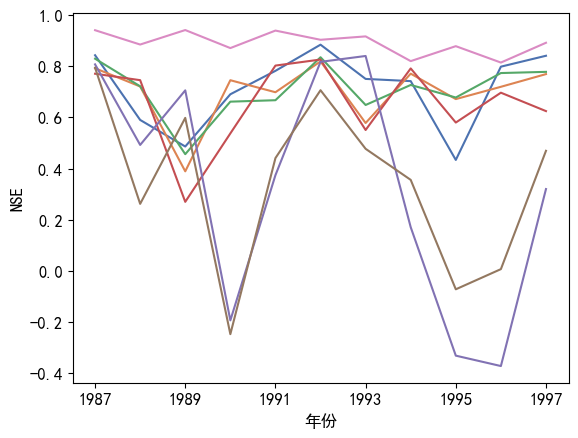

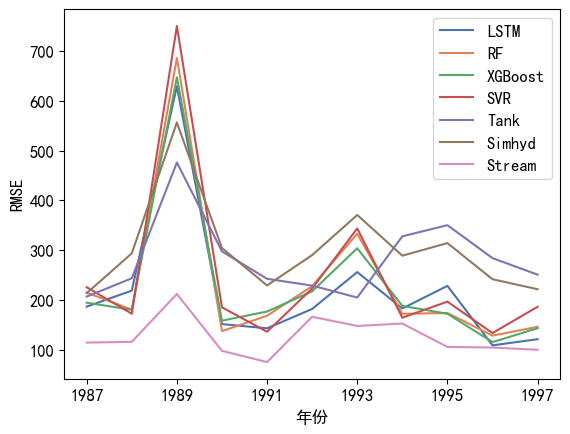

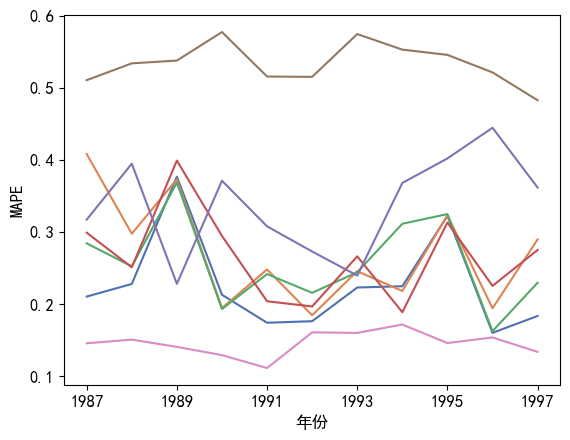

In [26]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def calculate_nse(data):
    obs = data[:,0]
    xgboost = data[:,1]
    rf = data[:,2]
    svr = data[:,3]
    lstm = data[:,4]
    tank = data[:,5]
    simhyd = data[:,6]
    stream = data[:,7]
    nse_xgboost = 1 - np.sum((obs-xgboost)**2)/np.sum((obs-np.mean(obs))**2)
    nse_rf = 1 - np.sum((obs-rf)**2)/np.sum((obs-np.mean(obs))**2)
    nse_svr = 1 - np.sum((obs-svr)**2)/np.sum((obs-np.mean(obs))**2)
    nse_lstm = 1 - np.sum((obs-lstm)**2)/np.sum((obs-np.mean(obs))**2)
    nse_tank = 1 - np.sum((obs-tank)**2)/np.sum((obs-np.mean(obs))**2)
    nse_simhyd = 1 - np.sum((obs-simhyd)**2)/np.sum((obs-np.mean(obs))**2)
    nse_stream = 1 - np.sum((obs-stream)**2)/np.sum((obs-np.mean(obs))**2)
    return nse_xgboost,nse_rf,nse_svr,nse_lstm,nse_tank,nse_simhyd,nse_stream

def calculate_rmse(data):
    obs = data[:,0]
    xgboost = data[:,1]
    rf = data[:,2]
    svr = data[:,3]
    lstm = data[:,4]
    tank = data[:,5]
    simhyd = data[:,6]
    stream = data[:,7]
    rmse_xgboost = np.sqrt(np.sum((obs-xgboost)**2)/len(obs))
    rmse_rf = np.sqrt(np.sum((obs-rf)**2)/len(obs)) 
    rmse_svr = np.sqrt(np.sum((obs-svr)**2)/len(obs))
    rmse_lstm = np.sqrt(np.sum((obs-lstm)**2)/len(obs))
    rmse_tank = np.sqrt(np.sum((obs-tank)**2)/len(obs))
    rmse_simhyd = np.sqrt(np.sum((obs-simhyd)**2)/len(obs))
    rmse_stream = np.sqrt(np.sum((obs-stream)**2)/len(obs))
    return rmse_xgboost,rmse_rf,rmse_svr,rmse_lstm,rmse_tank,rmse_simhyd,rmse_stream

def calculate_mae(data):
    obs = data[:,0]
    xgboost = data[:,1]
    rf = data[:,2]
    svr = data[:,3]
    lstm = data[:,4]
    tank = data[:,5]
    simhyd = data[:,6]
    stream = data[:,7]
    mae_xgboost = np.sum(np.abs(obs-xgboost))/len(obs)
    mae_rf = np.sum(np.abs(obs-rf))/len(obs)
    mae_svr = np.sum(np.abs(obs-svr))/len(obs)
    mae_lstm = np.sum(np.abs(obs-lstm))/len(obs)
    mae_tank = np.sum(np.abs(obs-tank))/len(obs)
    mae_simhyd = np.sum(np.abs(obs-simhyd))/len(obs)
    mae_stream = np.sum(np.abs(obs-stream))/len(obs)
    return mae_xgboost,mae_rf,mae_svr,mae_lstm,mae_tank,mae_simhyd,mae_stream

def calculate_mape(data):
    obs = data[:,0]
    xgboost = data[:,1]
    rf = data[:,2]
    svr = data[:,3]
    lstm = data[:,4]
    tank = data[:,5]
    simhyd = data[:,6]
    stream = data[:,7]
    mape_xgboost = np.sum(np.abs((obs-xgboost)/obs))/len(obs)
    mape_rf = np.sum(np.abs((obs-rf)/obs))/len(obs)
    mape_svr = np.sum(np.abs((obs-svr)/obs))/len(obs)
    mape_lstm = np.sum(np.abs((obs-lstm)/obs))/len(obs)
    mape_tank = np.sum(np.abs((obs-tank)/obs))/len(obs)
    mape_simhyd = np.sum(np.abs((obs-simhyd)/obs))/len(obs)
    mape_stream = np.sum(np.abs((obs-stream)/obs))/len(obs)
    return mape_xgboost,mape_rf,mape_svr,mape_lstm,mape_tank,mape_simhyd,mape_stream

results_87 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='87')
results_88 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='88')
results_89 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='89')
results_90 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='90')
results_91 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='91')
results_92 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='92')
results_93 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='93')
results_94 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='94')
results_95 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='95')
results_96 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='96')
results_97 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='97')

nse_xg_87,nse_rf_87,nse_svr_87,nse_lstm_87,nse_tank_87,nse_simhyd_87,nse_stream_87 = calculate_nse(np.array(results_87))
nse_xg_88,nse_rf_88,nse_svr_88,nse_lstm_88,nse_tank_88,nse_simhyd_88,nse_stream_88 = calculate_nse(np.array(results_88))
nse_xg_89,nse_rf_89,nse_svr_89,nse_lstm_89,nse_tank_89,nse_simhyd_89,nse_stream_89 = calculate_nse(np.array(results_89))
nse_xg_90,nse_rf_90,nse_svr_90,nse_lstm_90,nse_tank_90,nse_simhyd_90,nse_stream_90 = calculate_nse(np.array(results_90))
nse_xg_91,nse_rf_91,nse_svr_91,nse_lstm_91,nse_tank_91,nse_simhyd_91,nse_stream_91 = calculate_nse(np.array(results_91))
nse_xg_92,nse_rf_92,nse_svr_92,nse_lstm_92,nse_tank_92,nse_simhyd_92,nse_stream_92 = calculate_nse(np.array(results_92))
nse_xg_93,nse_rf_93,nse_svr_93,nse_lstm_93,nse_tank_93,nse_simhyd_93,nse_stream_93 = calculate_nse(np.array(results_93))
nse_xg_94,nse_rf_94,nse_svr_94,nse_lstm_94,nse_tank_94,nse_simhyd_94,nse_stream_94 = calculate_nse(np.array(results_94))
nse_xg_95,nse_rf_95,nse_svr_95,nse_lstm_95,nse_tank_95,nse_simhyd_95,nse_stream_95 = calculate_nse(np.array(results_95))
nse_xg_96,nse_rf_96,nse_svr_96,nse_lstm_96,nse_tank_96,nse_simhyd_96,nse_stream_96 = calculate_nse(np.array(results_96))
nse_xg_97,nse_rf_97,nse_svr_97,nse_lstm_97,nse_tank_97,nse_simhyd_97,nse_stream_97 = calculate_nse(np.array(results_97))

rmse_xg_87,rmse_rf_87,rmse_svr_87,rmse_lstm_87,rmse_tank_87,rmse_simhyd_87,rmse_stream_87 = calculate_rmse(np.array(results_87))
rmse_xg_88,rmse_rf_88,rmse_svr_88,rmse_lstm_88,rmse_tank_88,rmse_simhyd_88,rmse_stream_88 = calculate_rmse(np.array(results_88))
rmse_xg_89,rmse_rf_89,rmse_svr_89,rmse_lstm_89,rmse_tank_89,rmse_simhyd_89,rmse_stream_89 = calculate_rmse(np.array(results_89))
rmse_xg_90,rmse_rf_90,rmse_svr_90,rmse_lstm_90,rmse_tank_90,rmse_simhyd_90,rmse_stream_90 = calculate_rmse(np.array(results_90))
rmse_xg_91,rmse_rf_91,rmse_svr_91,rmse_lstm_91,rmse_tank_91,rmse_simhyd_91,rmse_stream_91 = calculate_rmse(np.array(results_91))
rmse_xg_92,rmse_rf_92,rmse_svr_92,rmse_lstm_92,rmse_tank_92,rmse_simhyd_92,rmse_stream_92 = calculate_rmse(np.array(results_92))
rmse_xg_93,rmse_rf_93,rmse_svr_93,rmse_lstm_93,rmse_tank_93,rmse_simhyd_93,rmse_stream_93 = calculate_rmse(np.array(results_93))
rmse_xg_94,rmse_rf_94,rmse_svr_94,rmse_lstm_94,rmse_tank_94,rmse_simhyd_94,rmse_stream_94 = calculate_rmse(np.array(results_94))
rmse_xg_95,rmse_rf_95,rmse_svr_95,rmse_lstm_95,rmse_tank_95,rmse_simhyd_95,rmse_stream_95 = calculate_rmse(np.array(results_95))
rmse_xg_96,rmse_rf_96,rmse_svr_96,rmse_lstm_96,rmse_tank_96,rmse_simhyd_96,rmse_stream_96 = calculate_rmse(np.array(results_96))
rmse_xg_97,rmse_rf_97,rmse_svr_97,rmse_lstm_97,rmse_tank_97,rmse_simhyd_97,rmse_stream_97 = calculate_rmse(np.array(results_97))

mae_xg_87,mae_rf_87,mae_svr_87,mae_lstm_87,mae_tank_87,mae_simhyd_87,mae_stream_87 = calculate_mae(np.array(results_87))
mae_xg_88,mae_rf_88,mae_svr_88,mae_lstm_88,mae_tank_88,mae_simhyd_88,mae_stream_88 = calculate_mae(np.array(results_88))
mae_xg_89,mae_rf_89,mae_svr_89,mae_lstm_89,mae_tank_89,mae_simhyd_89,mae_stream_89 = calculate_mae(np.array(results_89))
mae_xg_90,mae_rf_90,mae_svr_90,mae_lstm_90,mae_tank_90,mae_simhyd_90,mae_stream_90 = calculate_mae(np.array(results_90))
mae_xg_91,mae_rf_91,mae_svr_91,mae_lstm_91,mae_tank_91,mae_simhyd_91,mae_stream_91 = calculate_mae(np.array(results_91))
mae_xg_92,mae_rf_92,mae_svr_92,mae_lstm_92,mae_tank_92,mae_simhyd_92,mae_stream_92 = calculate_mae(np.array(results_92))
mae_xg_93,mae_rf_93,mae_svr_93,mae_lstm_93,mae_tank_93,mae_simhyd_93,mae_stream_93 = calculate_mae(np.array(results_93))
mae_xg_94,mae_rf_94,mae_svr_94,mae_lstm_94,mae_tank_94,mae_simhyd_94,mae_stream_94 = calculate_mae(np.array(results_94))
mae_xg_95,mae_rf_95,mae_svr_95,mae_lstm_95,mae_tank_95,mae_simhyd_95,mae_stream_95 = calculate_mae(np.array(results_95))
mae_xg_96,mae_rf_96,mae_svr_96,mae_lstm_96,mae_tank_96,mae_simhyd_96,mae_stream_96 = calculate_mae(np.array(results_96))    
mae_xg_97,mae_rf_97,mae_svr_97,mae_lstm_97,mae_tank_97,mae_simhyd_97,mae_stream_97 = calculate_mae(np.array(results_97))

mape_xg_87,mape_rf_87,mape_svr_87,mape_lstm_87,mape_tank_87,mape_simhyd_87,mape_stream_87 = calculate_mape(np.array(results_87))
mape_xg_88,mape_rf_88,mape_svr_88,mape_lstm_88,mape_tank_88,mape_simhyd_88,mape_stream_88 = calculate_mape(np.array(results_88))
mape_xg_89,mape_rf_89,mape_svr_89,mape_lstm_89,mape_tank_89,mape_simhyd_89,mape_stream_89 = calculate_mape(np.array(results_89))
mape_xg_90,mape_rf_90,mape_svr_90,mape_lstm_90,mape_tank_90,mape_simhyd_90,mape_stream_90 = calculate_mape(np.array(results_90))
mape_xg_91,mape_rf_91,mape_svr_91,mape_lstm_91,mape_tank_91,mape_simhyd_91,mape_stream_91 = calculate_mape(np.array(results_91))
mape_xg_92,mape_rf_92,mape_svr_92,mape_lstm_92,mape_tank_92,mape_simhyd_92,mape_stream_92 = calculate_mape(np.array(results_92))
mape_xg_93,mape_rf_93,mape_svr_93,mape_lstm_93,mape_tank_93,mape_simhyd_93,mape_stream_93 = calculate_mape(np.array(results_93))
mape_xg_94,mape_rf_94,mape_svr_94,mape_lstm_94,mape_tank_94,mape_simhyd_94,mape_stream_94 = calculate_mape(np.array(results_94))
mape_xg_95,mape_rf_95,mape_svr_95,mape_lstm_95,mape_tank_95,mape_simhyd_95,mape_stream_95 = calculate_mape(np.array(results_95))
mape_xg_96,mape_rf_96,mape_svr_96,mape_lstm_96,mape_tank_96,mape_simhyd_96,mape_stream_96 = calculate_mape(np.array(results_96))
mape_xg_97,mape_rf_97,mape_svr_97,mape_lstm_97,mape_tank_97,mape_simhyd_97,mape_stream_97 = calculate_mape(np.array(results_97))


data_nse = np.array([[nse_lstm_87,nse_rf_87,nse_xg_87,nse_svr_87,nse_tank_87,nse_simhyd_87,nse_stream_87],
                    [nse_lstm_88,nse_rf_88,nse_xg_88,nse_svr_88,nse_tank_88,nse_simhyd_88,nse_stream_88],
                    [nse_lstm_89,nse_rf_89,nse_xg_89,nse_svr_89,nse_tank_89,nse_simhyd_89,nse_stream_89],
                    [nse_lstm_90,nse_rf_90,nse_xg_90,nse_svr_90,nse_tank_90,nse_simhyd_90,nse_stream_90],
                    [nse_lstm_91,nse_rf_91,nse_xg_91,nse_svr_91,nse_tank_91,nse_simhyd_91,nse_stream_91],
                    [nse_lstm_92,nse_rf_92,nse_xg_92,nse_svr_92,nse_tank_92,nse_simhyd_92,nse_stream_92],
                    [nse_lstm_93,nse_rf_93,nse_xg_93,nse_svr_93,nse_tank_93,nse_simhyd_93,nse_stream_93],
                    [nse_lstm_94,nse_rf_94,nse_xg_94,nse_svr_94,nse_tank_94,nse_simhyd_94,nse_stream_94],
                    [nse_lstm_95,nse_rf_95,nse_xg_95,nse_svr_95,nse_tank_95,nse_simhyd_95,nse_stream_95],
                    [nse_lstm_96,nse_rf_96,nse_xg_96,nse_svr_96,nse_tank_96,nse_simhyd_96,nse_stream_96],
                    [nse_lstm_97,nse_rf_97,nse_xg_97,nse_svr_97,nse_tank_97,nse_simhyd_97,nse_stream_97]])
data_rmse = np.array([[rmse_lstm_87,rmse_rf_87,rmse_xg_87,rmse_svr_87,rmse_tank_87,rmse_simhyd_87,rmse_stream_87],
                      [rmse_lstm_88,rmse_rf_88,rmse_xg_88,rmse_svr_88,rmse_tank_88,rmse_simhyd_88,rmse_stream_88],
                        [rmse_lstm_89,rmse_rf_89,rmse_xg_89,rmse_svr_89,rmse_tank_89,rmse_simhyd_89,rmse_stream_89],
                        [rmse_lstm_90,rmse_rf_90,rmse_xg_90,rmse_svr_90,rmse_tank_90,rmse_simhyd_90,rmse_stream_90],
                        [rmse_lstm_91,rmse_rf_91,rmse_xg_91,rmse_svr_91,rmse_tank_91,rmse_simhyd_91,rmse_stream_91],
                        [rmse_lstm_92,rmse_rf_92,rmse_xg_92,rmse_svr_92,rmse_tank_92,rmse_simhyd_92,rmse_stream_92],
                        [rmse_lstm_93,rmse_rf_93,rmse_xg_93,rmse_svr_93,rmse_tank_93,rmse_simhyd_93,rmse_stream_93],
                        [rmse_lstm_94,rmse_rf_94,rmse_xg_94,rmse_svr_94,rmse_tank_94,rmse_simhyd_94,rmse_stream_94],
                        [rmse_lstm_95,rmse_rf_95,rmse_xg_95,rmse_svr_95,rmse_tank_95,rmse_simhyd_95,rmse_stream_95],
                        [rmse_lstm_96,rmse_rf_96,rmse_xg_96,rmse_svr_96,rmse_tank_96,rmse_simhyd_96,rmse_stream_96],
                        [rmse_lstm_97,rmse_rf_97,rmse_xg_97,rmse_svr_97,rmse_tank_97,rmse_simhyd_97,rmse_stream_97]])
data_mae = np.array([[mae_lstm_87,mae_rf_87,mae_xg_87,mae_svr_87,mae_tank_87,mae_simhyd_87,mae_stream_87],
                        [mae_lstm_88,mae_rf_88,mae_xg_88,mae_svr_88,mae_tank_88,mae_simhyd_88,mae_stream_88],
                        [mae_lstm_89,mae_rf_89,mae_xg_89,mae_svr_89,mae_tank_89,mae_simhyd_89,mae_stream_89],
                        [mae_lstm_90,mae_rf_90,mae_xg_90,mae_svr_90,mae_tank_90,mae_simhyd_90,mae_stream_90],
                        [mae_lstm_91,mae_rf_91,mae_xg_91,mae_svr_91,mae_tank_91,mae_simhyd_91,mae_stream_91],
                        [mae_lstm_92,mae_rf_92,mae_xg_92,mae_svr_92,mae_tank_92,mae_simhyd_92,mae_stream_92],
                        [mae_lstm_93,mae_rf_93,mae_xg_93,mae_svr_93,mae_tank_93,mae_simhyd_93,mae_stream_93],
                        [mae_lstm_94,mae_rf_94,mae_xg_94,mae_svr_94,mae_tank_94,mae_simhyd_94,mae_stream_94],
                        [mae_lstm_95,mae_rf_95,mae_xg_95,mae_svr_95,mae_tank_95,mae_simhyd_95,mae_stream_95],
                        [mae_lstm_96,mae_rf_96,mae_xg_96,mae_svr_96,mae_tank_96,mae_simhyd_96,mae_stream_96],
                        [mae_lstm_97,mae_rf_97,mae_xg_97,mae_svr_97,mae_tank_97,mae_simhyd_97,mae_stream_97]])
data_mape = np.array([[mape_lstm_87,mape_rf_87,mape_xg_87,mape_svr_87,mape_tank_87,mape_simhyd_87,mape_stream_87],
                    [mape_lstm_88,mape_rf_88,mape_xg_88,mape_svr_88,mape_tank_88,mape_simhyd_88,mape_stream_88],
                    [mape_lstm_89,mape_rf_89,mape_xg_89,mape_svr_89,mape_tank_89,mape_simhyd_89,mape_stream_89],
                    [mape_lstm_90,mape_rf_90,mape_xg_90,mape_svr_90,mape_tank_90,mape_simhyd_90,mape_stream_90],
                    [mape_lstm_91,mape_rf_91,mape_xg_91,mape_svr_91,mape_tank_91,mape_simhyd_91,mape_stream_91],
                    [mape_lstm_92,mape_rf_92,mape_xg_92,mape_svr_92,mape_tank_92,mape_simhyd_92,mape_stream_92],
                    [mape_lstm_93,mape_rf_93,mape_xg_93,mape_svr_93,mape_tank_93,mape_simhyd_93,mape_stream_93],
                    [mape_lstm_94,mape_rf_94,mape_xg_94,mape_svr_94,mape_tank_94,mape_simhyd_94,mape_stream_94],
                    [mape_lstm_95,mape_rf_95,mape_xg_95,mape_svr_95,mape_tank_95,mape_simhyd_95,mape_stream_95],
                    [mape_lstm_96,mape_rf_96,mape_xg_96,mape_svr_96,mape_tank_96,mape_simhyd_96,mape_stream_96],
                    [mape_lstm_97,mape_rf_97,mape_xg_97,mape_svr_97,mape_tank_97,mape_simhyd_97,mape_stream_97]])
                        


#设置行列名称
columns = ['LSTM','RF','XGBoost','SVR','Tank','Simhyd','Stream']
# index = ['1987-1989','1990-1992','1993-1995','1996-1997']
index = ['1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997']
# 用表格展示
df_nse = pd.DataFrame(data_nse, columns=columns, index=index)
df_rmse = pd.DataFrame(data_rmse, columns=columns, index=index)
df_mae = pd.DataFrame(data_mae, columns=columns, index=index)
df_mape = pd.DataFrame(data_mape, columns=columns, index=index)
print(df_nse)

sns.set_palette("deep")
#显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
#字体大小
plt.rcParams['font.size'] = 12


df_nse.plot()
#设置线宽
plt.rcParams['lines.linewidth'] = 1.5
plt.xlabel('年份')
plt.ylabel('NSE')
# plt.title('不同模型的NSE')
# plt.savefig(r'e:\work\data-stream\revision\10years-NSE.png',dpi=300)
plt.legend().remove()
plt.savefig(r'e:\work\毕设\图表\3-13NSE.png',dpi=300)
plt.show()


# df_mae.plot()
# #设置线宽
# plt.rcParams['lines.linewidth'] = 1.5
# plt.xlabel('Year')
# plt.ylabel('MAE')
# plt.title('不同模型的MAE')
# # plt.savefig(r'e:\work\data-stream\revision\10years-MAE.png',dpi=300)
# plt.show()

df_rmse.plot()
#设置线宽
plt.rcParams['lines.linewidth'] = 1.5
plt.xlabel('年份')
plt.ylabel('RMSE')
# plt.title('不同模型的RMSE')
# plt.legend().remove()
# plt.savefig(r'e:\work\data-stream\revision\10years-RMSE.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\3-13RMSE.png',dpi=300)
plt.show()

df_mape.plot()
#设置线宽
plt.rcParams['lines.linewidth'] = 1.5
plt.xlabel('年份')
plt.ylabel('MAPE')
# plt.title('MAPE of different models')
# plt.title('不同模型的MAPE')
#将legend固定在右上角
# plt.legend(loc='upper right')
# plt.savefig(r'e:\work\data-stream\revision\10years-MAPE.png',dpi=300)
#不显示图例
plt.legend().remove()
plt.savefig(r'e:\work\毕设\图表\3-13MAPE.png',dpi=300)
plt.show()

#绘制热力图


0.28638494061354 0.23526388544436566 0.2804127002008008
0.2659365185458703
0.006724933233285171 0.2646734833246965 0.43830937416352306 0.20513716477986527 0.0048756999104424305
-0.007288793825342227 0.3592908115683355 -0.46046209025544843 0.15409033992423546 0.004683781825452007
0.0033529088645698267 0.19826643301884003 0.22042814251538353 0.5998899429117229 0.006057079391024028


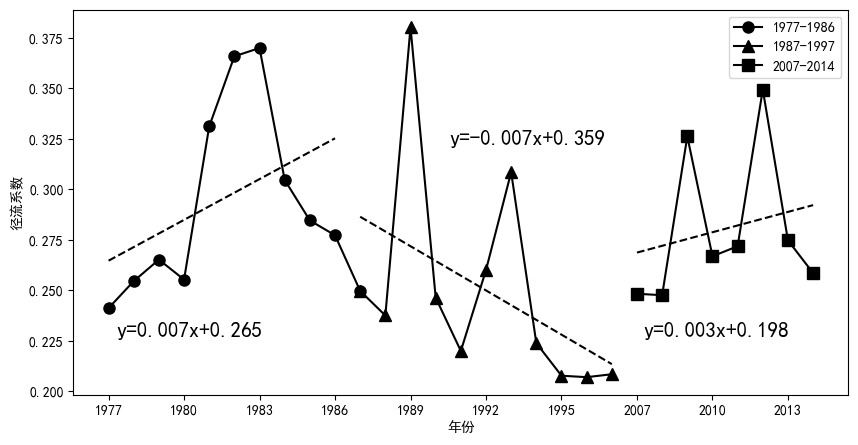

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

def calculate_runoff_depth(flow_rate, area_km2):
    """
    计算径流深度

    参数:
    flow_rate: 每日平均流速（立方米/秒）
    area_km2: 流域面积（平方公里）

    返回:
    日均径流深（毫米）
    """
    # 将面积从平方公里转换为平方米
    area_m2 = area_km2 * 1e6

    # 计算一天内流经该区域的总水体积（立方米）
    total_volume = flow_rate * 86400  # 一天有86400秒

    # 计算径流深（米），然后转换为毫米
    runoff_depth_mm = (total_volume / area_m2) * 1000

    return runoff_depth_mm


def calculate_cor(data):
    p1 = data[:,0]
    p2 = data[:,1]
    p3 = data[:,2]
    p4 = data[:,3]
    p5 = data[:,4]
    p6 = data[:,5]
    p7 = data[:,6]
    p8 = data[:,7]
    q = data[:,8]    
    area_example = 121972  # 平方公里
    q = calculate_runoff_depth(q, 121972)
   
    #计算径流系数
    cor_p1 = np.sum(q)/np.sum(p1)
    cor_p2 = np.sum(q)/np.sum(p2)
    cor_p3 = np.sum(q)/np.sum(p3)
    cor_p4 = np.sum(q)/np.sum(p4)
    cor_p5 = np.sum(q)/np.sum(p5)
    cor_p6 = np.sum(q)/np.sum(p6)
    cor_p7 = np.sum(q)/np.sum(p7)
    cor_p8 = np.sum(q)/np.sum(p8)
    #Pearson相关系数
    # cor_p1 = stats.pearsonr(p1,q)[0]
    # cor_p2 = stats.pearsonr(p2,q)[0]
    # cor_p3 = stats.pearsonr(p3,q)[0]
    # cor_p4 = stats.pearsonr(p4,q)[0]
    # cor_p5 = stats.pearsonr(p5,q)[0]
    # cor_p6 = stats.pearsonr(p6,q)[0]
    # cor_p7 = stats.pearsonr(p7,q)[0]
    # cor_p8 = stats.pearsonr(p8,q)[0]
    #线性斜率
    # slope_p1 = np.polyfit(p1,q,1)[0]
    # slope_p2 = np.polyfit(p2,q,1)[0]
    # slope_p3 = np.polyfit(p3,q,1)[0]
    # slope_p4 = np.polyfit(p4,q,1)[0]
    # slope_p5 = np.polyfit(p5,q,1)[0]
    # slope_p6 = np.polyfit(p6,q,1)[0]
    # slope_p7 = np.polyfit(p7,q,1)[0]
    # slope_p8 = np.polyfit(p8,q,1)[0]

    return cor_p1,cor_p2,cor_p3,cor_p4,cor_p5,cor_p6,cor_p7,cor_p8
    # return slope_p1,slope_p2,slope_p3,slope_p4,slope_p5,slope_p6,slope_p7,slope_p8
 
data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997_PQ.xlsx')
# data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997runoff_depth.xlsx')
data = np.array(data)
data = data[:,3:]
d1977 = data[:365,:]
d1978 = data[365:730,:]
d1979 = data[730:1095,:]
d1980 = data[1095:1461,:]
d1981 = data[1461:1826,:]
d1982 = data[1826:2191,:]
d1983 = data[2191:2556,:]
d1984 = data[2556:2922,:]
d1985 = data[2922:3287,:]
d1986 = data[3287:3652,:]
d1987 = data[3652:4018,:]
d1988 = data[4018:4384,:]
d1989 = data[4384:4749,:]
d1990 = data[4749:5114,:]
d1991 = data[5114:5479,:]
d1992 = data[5479:5845,:]
d1993 = data[5845:6210,:]
d1994 = data[6210:6575,:]
d1995 = data[6575:6940,:]
d1996 = data[6940:7306,:]
d1997 = data[7306:7671,:]
data_07_14 = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-2014\2007-2014_PQ.xlsx')
data_07_14 = np.array(data_07_14)
data_07_14 = data_07_14[:,3:]
d2007 = data_07_14[:365,:]
d2008 = data_07_14[365:731,:]
d2009 = data_07_14[731:1096,:]
d2010 = data_07_14[1096:1461,:]
d2011 = data_07_14[1461:1826,:]
d2012 = data_07_14[1826:2192,:]
d2013 = data_07_14[2192:2557,:]
d2014 = data_07_14[2557:,:]


cor1977_1,cor1977_2,cor1977_3,cor1977_4,cor1977_5,cor1977_6,cor1977_7,cor1977_8 = calculate_cor(d1977)
cor1978_1,cor1978_2,cor1978_3,cor1978_4,cor1978_5,cor1978_6,cor1978_7,cor1978_8 = calculate_cor(d1978)
cor1979_1,cor1979_2,cor1979_3,cor1979_4,cor1979_5,cor1979_6,cor1979_7,cor1979_8 = calculate_cor(d1979)
cor1980_1,cor1980_2,cor1980_3,cor1980_4,cor1980_5,cor1980_6,cor1980_7,cor1980_8 = calculate_cor(d1980)
cor1981_1,cor1981_2,cor1981_3,cor1981_4,cor1981_5,cor1981_6,cor1981_7,cor1981_8 = calculate_cor(d1981)
cor1982_1,cor1982_2,cor1982_3,cor1982_4,cor1982_5,cor1982_6,cor1982_7,cor1982_8 = calculate_cor(d1982)
cor1983_1,cor1983_2,cor1983_3,cor1983_4,cor1983_5,cor1983_6,cor1983_7,cor1983_8 = calculate_cor(d1983)
cor1984_1,cor1984_2,cor1984_3,cor1984_4,cor1984_5,cor1984_6,cor1984_7,cor1984_8 = calculate_cor(d1984)
cor1985_1,cor1985_2,cor1985_3,cor1985_4,cor1985_5,cor1985_6,cor1985_7,cor1985_8 = calculate_cor(d1985)
cor1986_1,cor1986_2,cor1986_3,cor1986_4,cor1986_5,cor1986_6,cor1986_7,cor1986_8 = calculate_cor(d1986)
cor1987_1,cor1987_2,cor1987_3,cor1987_4,cor1987_5,cor1987_6,cor1987_7,cor1987_8 = calculate_cor(d1987)
cor1988_1,cor1988_2,cor1988_3,cor1988_4,cor1988_5,cor1988_6,cor1988_7,cor1988_8 = calculate_cor(d1988)
cor1989_1,cor1989_2,cor1989_3,cor1989_4,cor1989_5,cor1989_6,cor1989_7,cor1989_8 = calculate_cor(d1989)
cor1990_1,cor1990_2,cor1990_3,cor1990_4,cor1990_5,cor1990_6,cor1990_7,cor1990_8 = calculate_cor(d1990)
cor1991_1,cor1991_2,cor1991_3,cor1991_4,cor1991_5,cor1991_6,cor1991_7,cor1991_8 = calculate_cor(d1991)
cor1992_1,cor1992_2,cor1992_3,cor1992_4,cor1992_5,cor1992_6,cor1992_7,cor1992_8 = calculate_cor(d1992)
cor1993_1,cor1993_2,cor1993_3,cor1993_4,cor1993_5,cor1993_6,cor1993_7,cor1993_8 = calculate_cor(d1993)
cor1994_1,cor1994_2,cor1994_3,cor1994_4,cor1994_5,cor1994_6,cor1994_7,cor1994_8 = calculate_cor(d1994)
cor1995_1,cor1995_2,cor1995_3,cor1995_4,cor1995_5,cor1995_6,cor1995_7,cor1995_8 = calculate_cor(d1995)
cor1996_1,cor1996_2,cor1996_3,cor1996_4,cor1996_5,cor1996_6,cor1996_7,cor1996_8 = calculate_cor(d1996)
cor1997_1,cor1997_2,cor1997_3,cor1997_4,cor1997_5,cor1997_6,cor1997_7,cor1997_8 = calculate_cor(d1997)

cor2007_1,cor2007_2,cor2007_3,cor2007_4,cor2007_5,cor2007_6,cor2007_7,cor2007_8 = calculate_cor(d2007)
cor2008_1,cor2008_2,cor2008_3,cor2008_4,cor2008_5,cor2008_6,cor2008_7,cor2008_8 = calculate_cor(d2008)
cor2009_1,cor2009_2,cor2009_3,cor2009_4,cor2009_5,cor2009_6,cor2009_7,cor2009_8 = calculate_cor(d2009)
cor2010_1,cor2010_2,cor2010_3,cor2010_4,cor2010_5,cor2010_6,cor2010_7,cor2010_8 = calculate_cor(d2010)
cor2011_1,cor2011_2,cor2011_3,cor2011_4,cor2011_5,cor2011_6,cor2011_7,cor2011_8 = calculate_cor(d2011)
cor2012_1,cor2012_2,cor2012_3,cor2012_4,cor2012_5,cor2012_6,cor2012_7,cor2012_8 = calculate_cor(d2012)
cor2013_1,cor2013_2,cor2013_3,cor2013_4,cor2013_5,cor2013_6,cor2013_7,cor2013_8 = calculate_cor(d2013)
cor2014_1,cor2014_2,cor2014_3,cor2014_4,cor2014_5,cor2014_6,cor2014_7,cor2014_8 = calculate_cor(d2014)


mean_77_88 = np.mean([cor1977_1,cor1977_2,cor1977_3,cor1977_4,cor1977_5,cor1977_6,cor1977_7,cor1977_8,
                    cor1978_1,cor1978_2,cor1978_3,cor1978_4,cor1978_5,cor1978_6,cor1978_7,cor1978_8,
                    cor1979_1,cor1979_2,cor1979_3,cor1979_4,cor1979_5,cor1979_6,cor1979_7,cor1979_8,
                    cor1980_1,cor1980_2,cor1980_3,cor1980_4,cor1980_5,cor1980_6,cor1980_7,cor1980_8,
                    cor1981_1,cor1981_2,cor1981_3,cor1981_4,cor1981_5,cor1981_6,cor1981_7,cor1981_8,
                    cor1982_1,cor1982_2,cor1982_3,cor1982_4,cor1982_5,cor1982_6,cor1982_7,cor1982_8,
                    cor1983_1,cor1983_2,cor1983_3,cor1983_4,cor1983_5,cor1983_6,cor1983_7,cor1983_8,
                    cor1984_1,cor1984_2,cor1984_3,cor1984_4,cor1984_5,cor1984_6,cor1984_7,cor1984_8,
                    cor1985_1,cor1985_2,cor1985_3,cor1985_4,cor1985_5,cor1985_6,cor1985_7,cor1985_8,
                    cor1986_1,cor1986_2,cor1986_3,cor1986_4,cor1986_5,cor1986_6,cor1986_7,cor1986_8,
                    cor1987_1,cor1987_2,cor1987_3,cor1987_4,cor1987_5,cor1987_6,cor1987_7,cor1987_8,
                    cor1988_1,cor1988_2,cor1988_3,cor1988_4,cor1988_5,cor1988_6,cor1988_7,cor1988_8])
mean_90_97 = np.mean([cor1990_1,cor1990_2,cor1990_3,cor1990_4,cor1990_5,cor1990_6,cor1990_7,cor1990_8,
                    cor1991_1,cor1991_2,cor1991_3,cor1991_4,cor1991_5,cor1991_6,cor1991_7,cor1991_8,
                    cor1992_1,cor1992_2,cor1992_3,cor1992_4,cor1992_5,cor1992_6,cor1992_7,cor1992_8,
                    cor1993_1,cor1993_2,cor1993_3,cor1993_4,cor1993_5,cor1993_6,cor1993_7,cor1993_8,
                    cor1994_1,cor1994_2,cor1994_3,cor1994_4,cor1994_5,cor1994_6,cor1994_7,cor1994_8,
                    cor1995_1,cor1995_2,cor1995_3,cor1995_4,cor1995_5,cor1995_6,cor1995_7,cor1995_8,
                    cor1996_1,cor1996_2,cor1996_3,cor1996_4,cor1996_5,cor1996_6,cor1996_7,cor1996_8,
                    cor1997_1,cor1997_2,cor1997_3,cor1997_4,cor1997_5,cor1997_6,cor1997_7,cor1997_8])
# print(mean_77_88,mean_90_97)

mean_77 = np.mean([cor1977_1,cor1977_2,cor1977_3,cor1977_4,cor1977_5,cor1977_6,cor1977_7,cor1977_8])
mean_78 = np.mean([cor1978_1,cor1978_2,cor1978_3,cor1978_4,cor1978_5,cor1978_6,cor1978_7,cor1978_8])
mean_79 = np.mean([cor1979_1,cor1979_2,cor1979_3,cor1979_4,cor1979_5,cor1979_6,cor1979_7,cor1979_8])
mean_80 = np.mean([cor1980_1,cor1980_2,cor1980_3,cor1980_4,cor1980_5,cor1980_6,cor1980_7,cor1980_8])
mean_81 = np.mean([cor1981_1,cor1981_2,cor1981_3,cor1981_4,cor1981_5,cor1981_6,cor1981_7,cor1981_8])
mean_82 = np.mean([cor1982_1,cor1982_2,cor1982_3,cor1982_4,cor1982_5,cor1982_6,cor1982_7,cor1982_8])
mean_83 = np.mean([cor1983_1,cor1983_2,cor1983_3,cor1983_4,cor1983_5,cor1983_6,cor1983_7,cor1983_8])
mean_84 = np.mean([cor1984_1,cor1984_2,cor1984_3,cor1984_4,cor1984_5,cor1984_6,cor1984_7,cor1984_8])
mean_85 = np.mean([cor1985_1,cor1985_2,cor1985_3,cor1985_4,cor1985_5,cor1985_6,cor1985_7,cor1985_8])
mean_86 = np.mean([cor1986_1,cor1986_2,cor1986_3,cor1986_4,cor1986_5,cor1986_6,cor1986_7,cor1986_8])
mean_87 = np.mean([cor1987_1,cor1987_2,cor1987_3,cor1987_4,cor1987_5,cor1987_6,cor1987_7,cor1987_8])
mean_88 = np.mean([cor1988_1,cor1988_2,cor1988_3,cor1988_4,cor1988_5,cor1988_6,cor1988_7,cor1988_8])
mean_89 = np.mean([cor1989_1,cor1989_2,cor1989_3,cor1989_4,cor1989_5,cor1989_6,cor1989_7,cor1989_8])
mean_90 = np.mean([cor1990_1,cor1990_2,cor1990_3,cor1990_4,cor1990_5,cor1990_6,cor1990_7,cor1990_8])
mean_91 = np.mean([cor1991_1,cor1991_2,cor1991_3,cor1991_4,cor1991_5,cor1991_6,cor1991_7,cor1991_8])
mean_92 = np.mean([cor1992_1,cor1992_2,cor1992_3,cor1992_4,cor1992_5,cor1992_6,cor1992_7,cor1992_8])
mean_93 = np.mean([cor1993_1,cor1993_2,cor1993_3,cor1993_4,cor1993_5,cor1993_6,cor1993_7,cor1993_8])
mean_94 = np.mean([cor1994_1,cor1994_2,cor1994_3,cor1994_4,cor1994_5,cor1994_6,cor1994_7,cor1994_8])
mean_95 = np.mean([cor1995_1,cor1995_2,cor1995_3,cor1995_4,cor1995_5,cor1995_6,cor1995_7,cor1995_8])
mean_96 = np.mean([cor1996_1,cor1996_2,cor1996_3,cor1996_4,cor1996_5,cor1996_6,cor1996_7,cor1996_8])
mean_97 = np.mean([cor1997_1,cor1997_2,cor1997_3,cor1997_4,cor1997_5,cor1997_6,cor1997_7,cor1997_8])

mean_07 = np.mean([cor2007_1,cor2007_2,cor2007_3,cor2007_4,cor2007_5,cor2007_6,cor2007_7,cor2007_8])
mean_08 = np.mean([cor2008_1,cor2008_2,cor2008_3,cor2008_4,cor2008_5,cor2008_6,cor2008_7,cor2008_8])
mean_09 = np.mean([cor2009_1,cor2009_2,cor2009_3,cor2009_4,cor2009_5,cor2009_6,cor2009_7,cor2009_8])
mean_10 = np.mean([cor2010_1,cor2010_2,cor2010_3,cor2010_4,cor2010_5,cor2010_6,cor2010_7,cor2010_8])
mean_11 = np.mean([cor2011_1,cor2011_2,cor2011_3,cor2011_4,cor2011_5,cor2011_6,cor2011_7,cor2011_8])
mean_12 = np.mean([cor2012_1,cor2012_2,cor2012_3,cor2012_4,cor2012_5,cor2012_6,cor2012_7,cor2012_8])
mean_13 = np.mean([cor2013_1,cor2013_2,cor2013_3,cor2013_4,cor2013_5,cor2013_6,cor2013_7,cor2013_8])
mean_14 = np.mean([cor2014_1,cor2014_2,cor2014_3,cor2014_4,cor2014_5,cor2014_6,cor2014_7,cor2014_8])


data_frame_annual = np.array((mean_77,mean_78,mean_79,mean_80,mean_81,mean_82,mean_83,mean_84,mean_85,mean_86,mean_87,mean_88,mean_89,mean_90,
                              mean_91,mean_92,mean_93,mean_94,mean_95,mean_96,mean_97,
                              mean_07,mean_08,mean_09,mean_10,mean_11,mean_12,mean_13,mean_14))
data_frame_annual = pd.DataFrame(data_frame_annual)
columns_years=['1977','1978','1979','1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990',
               '1991','1992','1993','1994','1995','1996','1997',
               '2007','2008','2009','2010','2011','2012','2013','2014']
data_frame_annual.index = columns_years

# 所有累计降水与径流
def mean_sum_runoff_coe(data):
    p1 = np.sum(data[:,0])
    p2 = np.sum(data[:,1])
    p3 = np.sum(data[:,2])
    p4 = np.sum(data[:,3])
    p5 = np.sum(data[:,4])
    p6 = np.sum(data[:,5])
    p7 = np.sum(data[:,6])
    p8 = np.sum(data[:,7])
    mean_p = np.mean((p1,p2,p3,p4,p5,p6,p7,p8))
    q = calculate_runoff_depth(data[:,-1], 121972)
    sum_q = np.sum(q)
    rc = sum_q/mean_p
    return rc
rc_77 = mean_sum_runoff_coe(d1977)
rc_78 = mean_sum_runoff_coe(d1978)
rc_79 = mean_sum_runoff_coe(d1979)
rc_80 = mean_sum_runoff_coe(d1980)
rc_81 = mean_sum_runoff_coe(d1981)
rc_82 = mean_sum_runoff_coe(d1982)
rc_83 = mean_sum_runoff_coe(d1983)
rc_84 = mean_sum_runoff_coe(d1984)
rc_85 = mean_sum_runoff_coe(d1985)
rc_86 = mean_sum_runoff_coe(d1986)
rc_87 = mean_sum_runoff_coe(d1987)
rc_88 = mean_sum_runoff_coe(d1988)
rc_89 = mean_sum_runoff_coe(d1989)
rc_90 = mean_sum_runoff_coe(d1990)
rc_91 = mean_sum_runoff_coe(d1991)
rc_92 = mean_sum_runoff_coe(d1992)
rc_93 = mean_sum_runoff_coe(d1993)
rc_94 = mean_sum_runoff_coe(d1994)
rc_95 = mean_sum_runoff_coe(d1995)
rc_96 = mean_sum_runoff_coe(d1996)
rc_97 = mean_sum_runoff_coe(d1997)

rc_07 = mean_sum_runoff_coe(d2007)
rc_08 = mean_sum_runoff_coe(d2008)
rc_09 = mean_sum_runoff_coe(d2009)
rc_10 = mean_sum_runoff_coe(d2010)
rc_11 = mean_sum_runoff_coe(d2011)
rc_12 = mean_sum_runoff_coe(d2012)
rc_13 = mean_sum_runoff_coe(d2013)
rc_14 = mean_sum_runoff_coe(d2014)

data_frame_rc = np.array((rc_77,rc_78,rc_79,rc_80,rc_81,rc_82,rc_83,rc_84,rc_85,rc_86,rc_87,rc_88,rc_89,rc_90,
                          rc_91,rc_92,rc_93,rc_94,rc_95,rc_96,rc_97,
                            rc_07,rc_08,rc_09,rc_10,rc_11,rc_12,rc_13,rc_14))
data_frame_rc = pd.DataFrame(data_frame_rc)
data_frame_rc.index = ['1977','1978','1979','1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990',
                       '1991','1992','1993','1994','1995','1996','1997',
                       '2007','2008','2009','2010','2011','2012','2013','2014']

mean_1977_1988_rc = np.mean((rc_77,rc_78,rc_79,rc_80,rc_81,rc_82,rc_83,rc_84,rc_85,rc_86,rc_87,rc_88))
mean_1990_1997_rc = np.mean((rc_90,rc_91,rc_92,rc_93,rc_94,rc_95,rc_96,rc_97))
mean_2007_2014_rc = np.mean((rc_07,rc_08,rc_09,rc_10,rc_11,rc_12,rc_13,rc_14))
mean_1977_1997_rc = np.mean((rc_77,rc_78,rc_79,rc_80,rc_81,rc_82,rc_83,rc_84,rc_85,rc_86,rc_87,rc_88,rc_90,rc_91,rc_92,rc_93,rc_94,rc_95,rc_96,rc_97))
print(mean_1977_1988_rc,mean_1990_1997_rc,mean_2007_2014_rc)
print(mean_1977_1997_rc)



data_frame = pd.DataFrame([[cor1977_1,cor1977_2,cor1977_3,cor1977_4,cor1977_5,cor1977_6,cor1977_7,cor1977_8],
[cor1978_1,cor1978_2,cor1978_3,cor1978_4,cor1978_5,cor1978_6,cor1978_7,cor1978_8],
[cor1979_1,cor1979_2,cor1979_3,cor1979_4,cor1979_5,cor1979_6,cor1979_7,cor1979_8],
[cor1980_1,cor1980_2,cor1980_3,cor1980_4,cor1980_5,cor1980_6,cor1980_7,cor1980_8],
[cor1981_1,cor1981_2,cor1981_3,cor1981_4,cor1981_5,cor1981_6,cor1981_7,cor1981_8],
[cor1982_1,cor1982_2,cor1982_3,cor1982_4,cor1982_5,cor1982_6,cor1982_7,cor1982_8],
[cor1983_1,cor1983_2,cor1983_3,cor1983_4,cor1983_5,cor1983_6,cor1983_7,cor1983_8],
[cor1984_1,cor1984_2,cor1984_3,cor1984_4,cor1984_5,cor1984_6,cor1984_7,cor1984_8],
[cor1985_1,cor1985_2,cor1985_3,cor1985_4,cor1985_5,cor1985_6,cor1985_7,cor1985_8],
[cor1986_1,cor1986_2,cor1986_3,cor1986_4,cor1986_5,cor1986_6,cor1986_7,cor1986_8],
[cor1987_1,cor1987_2,cor1987_3,cor1987_4,cor1987_5,cor1987_6,cor1987_7,cor1987_8],
[cor1988_1,cor1988_2,cor1988_3,cor1988_4,cor1988_5,cor1988_6,cor1988_7,cor1988_8],
[cor1989_1,cor1989_2,cor1989_3,cor1989_4,cor1989_5,cor1989_6,cor1989_7,cor1989_8],
[cor1990_1,cor1990_2,cor1990_3,cor1990_4,cor1990_5,cor1990_6,cor1990_7,cor1990_8],
[cor1991_1,cor1991_2,cor1991_3,cor1991_4,cor1991_5,cor1991_6,cor1991_7,cor1991_8],
[cor1992_1,cor1992_2,cor1992_3,cor1992_4,cor1992_5,cor1992_6,cor1992_7,cor1992_8],
[cor1993_1,cor1993_2,cor1993_3,cor1993_4,cor1993_5,cor1993_6,cor1993_7,cor1993_8],
[cor1994_1,cor1994_2,cor1994_3,cor1994_4,cor1994_5,cor1994_6,cor1994_7,cor1994_8],
[cor1995_1,cor1995_2,cor1995_3,cor1995_4,cor1995_5,cor1995_6,cor1995_7,cor1995_8],
[cor1996_1,cor1996_2,cor1996_3,cor1996_4,cor1996_5,cor1996_6,cor1996_7,cor1996_8],
[cor1997_1,cor1997_2,cor1997_3,cor1997_4,cor1997_5,cor1997_6,cor1997_7,cor1997_8],
[cor2007_1,cor2007_2,cor2007_3,cor2007_4,cor2007_5,cor2007_6,cor2007_7,cor2007_8],
[cor2008_1,cor2008_2,cor2008_3,cor2008_4,cor2008_5,cor2008_6,cor2008_7,cor2008_8],
[cor2009_1,cor2009_2,cor2009_3,cor2009_4,cor2009_5,cor2009_6,cor2009_7,cor2009_8],
[cor2010_1,cor2010_2,cor2010_3,cor2010_4,cor2010_5,cor2010_6,cor2010_7,cor2010_8],
[cor2011_1,cor2011_2,cor2011_3,cor2011_4,cor2011_5,cor2011_6,cor2011_7,cor2011_8],
[cor2012_1,cor2012_2,cor2012_3,cor2012_4,cor2012_5,cor2012_6,cor2012_7,cor2012_8],
[cor2013_1,cor2013_2,cor2013_3,cor2013_4,cor2013_5,cor2013_6,cor2013_7,cor2013_8],
[cor2014_1,cor2014_2,cor2014_3,cor2014_4,cor2014_5,cor2014_6,cor2014_7,cor2014_8]],
columns=['Maduo','Dari','Guoluo','Xinghai','Ruoergai','Jiuzhi','Henan','Hongyuan'])

data_frame.index = ['1977','1978','1979','1980','1981','1982','1983','1984','1985','1986',
'1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997',
'2007','2008','2009','2010','2011','2012','2013','2014']

# print(np.array(data_frame_annual).shape)
slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(np.arange(10),np.array(data_frame_rc.iloc[:10]).reshape(1,10))
print(slope_1, intercept_1, r_value_1, p_value_1, std_err_1)

slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(np.arange(10,21),np.array(data_frame_rc.iloc[10:21]).reshape(1,11))
print(slope_2, intercept_2, r_value_2, p_value_2, std_err_2)

slope_3, intercept_3, r_value_3, p_value_3, std_err_3 = stats.linregress(np.arange(21,29),np.array(data_frame_rc.iloc[21:]).reshape(1,8))
print(slope_3, intercept_3, r_value_3, p_value_3, std_err_3)
# print(data_frame)
import seaborn as sns

# plt.rcParams['font.sans-serif'] = ['Aria']  # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
#中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False



sns.set_palette("deep")
plt.figure(figsize=(10,5))

# plt.plot(data_frame_rc.iloc[0:11],label='1977-1986',color='steelblue',marker='o',markersize=5,linewidth=1.5)
# plt.plot(data_frame_rc.iloc[10:21],label='1987-1997',color='green',marker='o',markersize=5,linewidth=1.5)
# plt.plot(data_frame_rc.iloc[21:],label='2007-2014',color='peru',marker='o',markersize=5,linewidth=1.5)
plt.plot(data_frame_rc.iloc[0:11],label='1977-1986',color='black',marker='o',markersize=8,linewidth=1.5)
plt.plot(data_frame_rc.iloc[10:21],label='1987-1997',color='black',marker='^',markersize=8,linewidth=1.5)
plt.plot(data_frame_rc.iloc[21:],label='2007-2014',color='black',marker='s',markersize=8,linewidth=1.5)

# plt.axhline(y=mean_77_88, xmin=0, xmax=11/20, color='black', linestyle='--')  
# plt.axhline(y=mean_90_97, xmin=12/20, xmax=20, color='black', linestyle='--')
# plt.plot([], [], color='black', linestyle='--', label='Mean')

plt.plot(np.arange(10),np.arange(10)*slope_1+intercept_1,color='black',linestyle='--',linewidth=1.5)
plt.plot(np.arange(10,21),np.arange(10,21)*slope_2+intercept_2,color='black',linestyle='--',linewidth=1.5)
plt.plot(np.arange(21,29),np.arange(21,29)*slope_3+intercept_3,color='black',linestyle='--',linewidth=1.5)
plt.text(0.055,0.15,'y=0.007x+0.265',transform=plt.gca().transAxes,fontsize=15)
# plt.text(0.055,0.08,'p<0.05',transform=plt.gca().transAxes,fontsize=15)
plt.text(0.485,0.65,'y=-0.007x+0.359',transform=plt.gca().transAxes,fontsize=15)
# plt.text(0.735,0.08,'p<0.05',transform=plt.gca().transAxes,fontsize=15)
plt.text(0.735,0.15,'y=0.003x+0.198',transform=plt.gca().transAxes,fontsize=15)

plt.xticks(np.arange(29),['1977','1978','1979','1980','1981','1982','1983','1984','1985','1986',
'1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997',
'2007','2008','2009','2010','2011','2012','2013','2014'])
plt.xticks(np.arange(0, 29, 3))

plt.legend(loc='upper right')
# plt.xlabel('year')
# plt.ylabel('runoff coefficient')
plt.xlabel('年份')
plt.ylabel('径流系数')
# plt.ylabel('slope')
#额外添加一个图例
# plt.plot([], [], color='black', linestyle='--', label='Mean 1990-1997')
# plt.text(0.005,0.95,'Mean(1977-1988)=0.039',transform=plt.gca().transAxes,fontsize=8)
# plt.text(0.005,0.9,'Mean(1990-1997)=0.024',transform=plt.gca().transAxes,fontsize=8)

#保存并设置dpi
# plt.savefig(r'e:\work\data-stream\revision\1977-2014_runoffcoe.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\2-5.png',dpi=300)
plt.show()


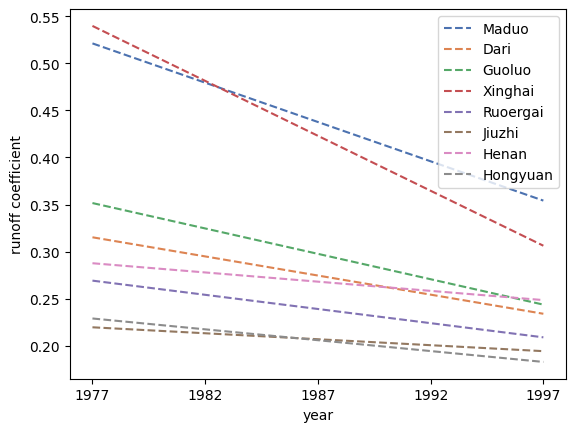

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Maduo = np.array([cor1977_1,cor1978_1,cor1979_1,cor1980_1,cor1981_1,cor1982_1,cor1983_1,cor1984_1,cor1985_1,cor1986_1,cor1987_1,cor1988_1,cor1989_1,cor1990_1,cor1991_1,cor1992_1,cor1993_1,cor1994_1,cor1995_1,cor1996_1,cor1997_1])
Dari = np.array([cor1977_2,cor1978_2,cor1979_2,cor1980_2,cor1981_2,cor1982_2,cor1983_2,cor1984_2,cor1985_2,cor1986_2,cor1987_2,cor1988_2,cor1989_2,cor1990_2,cor1991_2,cor1992_2,cor1993_2,cor1994_2,cor1995_2,cor1996_2,cor1997_2])
Guoluo = np.array([cor1977_3,cor1978_3,cor1979_3,cor1980_3,cor1981_3,cor1982_3,cor1983_3,cor1984_3,cor1985_3,cor1986_3,cor1987_3,cor1988_3,cor1989_3,cor1990_3,cor1991_3,cor1992_3,cor1993_3,cor1994_3,cor1995_3,cor1996_3,cor1997_3])
Xinghai = np.array([cor1977_4,cor1978_4,cor1979_4,cor1980_4,cor1981_4,cor1982_4,cor1983_4,cor1984_4,cor1985_4,cor1986_4,cor1987_4,cor1988_4,cor1989_4,cor1990_4,cor1991_4,cor1992_4,cor1993_4,cor1994_4,cor1995_4,cor1996_4,cor1997_4])
Ruoergai = np.array([cor1977_5,cor1978_5,cor1979_5,cor1980_5,cor1981_5,cor1982_5,cor1983_5,cor1984_5,cor1985_5,cor1986_5,cor1987_5,cor1988_5,cor1989_5,cor1990_5,cor1991_5,cor1992_5,cor1993_5,cor1994_5,cor1995_5,cor1996_5,cor1997_5])
Jiuzhi = np.array([cor1977_6,cor1978_6,cor1979_6,cor1980_6,cor1981_6,cor1982_6,cor1983_6,cor1984_6,cor1985_6,cor1986_6,cor1987_6,cor1988_6,cor1989_6,cor1990_6,cor1991_6,cor1992_6,cor1993_6,cor1994_6,cor1995_6,cor1996_6,cor1997_6])
Henan = np.array([cor1977_7,cor1978_7,cor1979_7,cor1980_7,cor1981_7,cor1982_7,cor1983_7,cor1984_7,cor1985_7,cor1986_7,cor1987_7,cor1988_7,cor1989_7,cor1990_7,cor1991_7,cor1992_7,cor1993_7,cor1994_7,cor1995_7,cor1996_7,cor1997_7])
Hongyuan = np.array([cor1977_8,cor1978_8,cor1979_8,cor1980_8,cor1981_8,cor1982_8,cor1983_8,cor1984_8,cor1985_8,cor1986_8,cor1987_8,cor1988_8,cor1989_8,cor1990_8,cor1991_8,cor1992_8,cor1993_8,cor1994_8,cor1995_8,cor1996_8,cor1997_8])

#进行线性回归
slope_maduo, intercept_maduo, r_value_maduo, p_value_maduo, std_err_maduo = stats.linregress(np.arange(21),Maduo)
slope_dari, intercept_dari, r_value_dari, p_value_dari, std_err_dari = stats.linregress(np.arange(21),Dari)
slope_guoluo, intercept_guoluo, r_value_guoluo, p_value_guoluo, std_err_guoluo = stats.linregress(np.arange(21),Guoluo)
slope_xinghai, intercept_xinghai, r_value_xinghai, p_value_xinghai, std_err_xinghai = stats.linregress(np.arange(21),Xinghai)
slope_ruoergai, intercept_ruoergai, r_value_ruoergai, p_value_ruoergai, std_err_ruoergai = stats.linregress(np.arange(21),Ruoergai)
slope_jiuzhi, intercept_jiuzhi, r_value_jiuzhi, p_value_jiuzhi, std_err_jiuzhi = stats.linregress(np.arange(21),Jiuzhi)
slope_henan, intercept_henan, r_value_henan, p_value_henan, std_err_henan = stats.linregress(np.arange(21),Henan)
slope_hongyuan, intercept_hongyuan, r_value_hongyuan, p_value_hongyuan, std_err_hongyuan = stats.linregress(np.arange(21),Hongyuan)
import seaborn as sns
sns.set_palette("deep")
#绘制线性回归图
plt.plot(np.arange(21),slope_maduo*np.arange(21)+intercept_maduo,linestyle='--')
plt.plot(np.arange(21),slope_dari*np.arange(21)+intercept_dari,linestyle='--')
plt.plot(np.arange(21),slope_guoluo*np.arange(21)+intercept_guoluo,linestyle='--')
plt.plot(np.arange(21),slope_xinghai*np.arange(21)+intercept_xinghai,linestyle='--')
plt.plot(np.arange(21),slope_ruoergai*np.arange(21)+intercept_ruoergai,linestyle='--')
plt.plot(np.arange(21),slope_jiuzhi*np.arange(21)+intercept_jiuzhi,linestyle='--')
plt.plot(np.arange(21),slope_henan*np.arange(21)+intercept_henan,linestyle='--')
plt.plot(np.arange(21),slope_hongyuan*np.arange(21)+intercept_hongyuan,linestyle='--')
#绘制散点图
# plt.scatter(np.arange(21),Maduo,color='red',marker='o')
# plt.scatter(np.arange(21),Dari,color='blue',marker='o')
# plt.scatter(np.arange(21),Guoluo,color='green',marker='o')
# plt.scatter(np.arange(21),Xinghai,color='black',marker='o')
# plt.scatter(np.arange(21),Ruoergai,color='orange',marker='o')
# plt.scatter(np.arange(21),Jiuzhi,color='pink',marker='o')
# plt.scatter(np.arange(21),Henan,color='purple',marker='o')
# plt.scatter(np.arange(21),Hongyuan,color='yellow',marker='o')
#添加图例
plt.legend(['Maduo','Dari','Guoluo','Xinghai','Ruoergai','Jiuzhi','Henan','Hongyuan'])
plt.xlabel('year')
plt.xticks(np.arange(21),['1977','1978','1979','1980','1981','1982','1983','1984','1985','1986',
'1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997'])
#xticks每5个值对应一个标签
plt.xticks(np.arange(0, 21, 5))

plt.ylabel('runoff coefficient')
#保存并设置dpi
# plt.savefig(r'e:\work\data-stream\revision\slope.png',dpi=300)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

tank = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\tank_87-97.xlsx'))[:,1]
simhyd = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\simhyd_87-97.xlsx'))[:,1]
lstm = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\pred_lstm_87-97.xlsx'))[:,1]
rf = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\onetrain_rfxgsvr_87-97.xlsx'))[:,3]
xgboost = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\onetrain_rfxgsvr_87-97.xlsx'))[:,2]
svr = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\onetrain_rfxgsvr_87-97.xlsx'))[:,4]
obs = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\onetrain_rfxgsvr_87-97.xlsx'))[:,1]



# #建立时间索引
# index = pd.date_range('1987-01-31','1997-12-30')
# #建立dataframe
# data = np.array([obs,lstm,rf,xgboost,svr,tank,simhyd])
# data = pd.DataFrame(data.T,index=index,columns=['obs','lstm','rf','xgboost','svr','tank','simhyd'])
# print(data)
# sys.exit()

#计算nse
nse_tank = 1 - np.sum((obs-tank)**2)/np.sum((obs-np.mean(obs))**2)
nse_simhyd = 1 - np.sum((obs-simhyd)**2)/np.sum((obs-np.mean(obs))**2)
nse_lstm = 1 - np.sum((obs-lstm)**2)/np.sum((obs-np.mean(obs))**2)
nse_rf = 1 - np.sum((obs-rf)**2)/np.sum((obs-np.mean(obs))**2)
nse_xgboost = 1 - np.sum((obs-xgboost)**2)/np.sum((obs-np.mean(obs))**2)
nse_svr = 1 - np.sum((obs-svr)**2)/np.sum((obs-np.mean(obs))**2)

#计算rmse
rmse_tank = np.sqrt(np.sum((obs-tank)**2)/len(obs))
rmse_simhyd = np.sqrt(np.sum((obs-simhyd)**2)/len(obs))
rmse_lstm = np.sqrt(np.sum((obs-lstm)**2)/len(obs))
rmse_rf = np.sqrt(np.sum((obs-rf)**2)/len(obs))
rmse_xgboost = np.sqrt(np.sum((obs-xgboost)**2)/len(obs))
rmse_svr = np.sqrt(np.sum((obs-svr)**2)/len(obs))

#计算mae
mae_tank = np.sum(np.abs(obs-tank))/len(obs)
mae_simhyd = np.sum(np.abs(obs-simhyd))/len(obs)
mae_lstm = np.sum(np.abs(obs-lstm))/len(obs)
mae_rf = np.sum(np.abs(obs-rf))/len(obs)
mae_xgboost = np.sum(np.abs(obs-xgboost))/len(obs)
mae_svr = np.sum(np.abs(obs-svr))/len(obs)

#计算mape
mape_tank = np.sum(np.abs(obs-tank)/obs)/len(obs)
mape_simhyd = np.sum(np.abs(obs-simhyd)/obs)/len(obs)
mape_lstm = np.sum(np.abs(obs-lstm)/obs)/len(obs)
mape_rf = np.sum(np.abs(obs-rf)/obs)/len(obs)
mape_xgboost = np.sum(np.abs(obs-xgboost)/obs)/len(obs)
mape_svr = np.sum(np.abs(obs-svr)/obs)/len(obs)

#建立dataframe
data = np.array([[nse_lstm,nse_rf,nse_xgboost,nse_svr,nse_tank,nse_simhyd],
                [rmse_lstm,rmse_rf,rmse_xgboost,rmse_svr,rmse_tank,rmse_simhyd],
                [mae_lstm,mae_rf,mae_xgboost,mae_svr,mae_tank,mae_simhyd],
                [mape_lstm,mape_rf,mape_xgboost,mape_svr,mape_tank,mape_simhyd]])
data = pd.DataFrame(data,columns=['LSTM','RF','XGBoost','SVR','Tank','SimHyd'],index=['NSE','RMSE','MAE','MAPE'])

# print(data)
                 

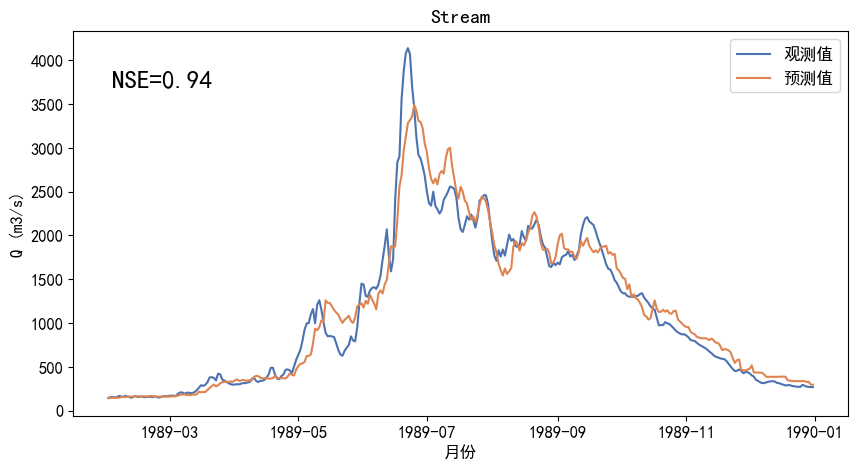

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
results_87 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='87')
results_88 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='88')
results_89 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='89')
results_90 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='90')
results_91 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='91')
results_92 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='92')
results_93 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='93')
results_94 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='94')
results_95 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='95')
results_96 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='96')
results_97 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='97')

# results_87 = np.array(results_87)#;print(results_87.shape)
# results_88 = np.array(results_88)#;print(results_88.shape)
# results_89 = np.array(results_89)#;print(results_89.shape)
# results_90 = np.array(results_90)#;print(results_90.shape)
# results_91 = np.array(results_91)#;print(results_91.shape)
# results_92 = np.array(results_92)#;print(results_92.shape)
# results_93 = np.array(results_93)#;print(results_93.shape)
# results_94 = np.array(results_94)#;print(results_94.shape)
# results_95 = np.array(results_95)#;print(results_95.shape)
# results_96 = np.array(results_96)#;print(results_96.shape)
# results_97 = np.array(results_97)#;print(results_97.shape)

# #89 93 
data = results_89
obs = data['obs']
lstm = data['lstm']
rf = data['rf']
xgboost = data['xgboost']
svr = data['svr']
tank = data['tank']
simhyd = data['simhyd']
stream = data['stream']

# diff_lstm = np.abs(obs-lstm)
# diff_rf = np.abs(obs-rf)
# diff_xgboost = np.abs(obs-xgboost)
# diff_svr = np.abs(obs-svr)
# diff_tank = np.abs(obs-tank)
# diff_simhyd = np.abs(obs-simhyd)
# diff_stream = np.abs(obs-stream)

# plt.plot(diff_lstm,label='LSTM')
# plt.plot(diff_rf,label='RF')
# plt.plot(diff_xgboost,label='XGBoost')
# plt.plot(diff_svr,label='SVR')
# plt.plot(diff_tank,label='Tank')
# plt.plot(diff_simhyd,label='SimHyd')
# plt.plot(diff_stream,label='Stream')
# plt.legend(loc='upper right')
# plt.show()

#添加时间索引
# index = pd.date_range('1993-01-31','1993-12-31')
index = pd.date_range('1989-01-31','1989-12-31')
sns.set_palette("deep")
#显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,5))
# plt.plot(index,obs,label='observation')
plt.plot(index,obs,label='观测值')
# plt.plot(index,lstm,label='LSTM')
# plt.plot(index,rf,label='RF')
# plt.plot(index,xgboost,label='XGBoost')
# plt.plot(index,svr,label='SVR')
# plt.plot(index,tank,label='Tank')
# plt.plot(index,simhyd,label='Simhyd')
# plt.plot(index,stream,label='Stream')
plt.plot(index,stream,label='预测值')
plt.legend(loc='upper right')


plt.rcParams['lines.linewidth'] = 1.5
plt.xlabel('月份')
plt.ylabel('Q (m3/s)')
# plt.title('Prediction of Simhyd model in 1993')
plt.title('Stream')
plt.text(0.05,0.85,'NSE=0.94',transform=plt.gca().transAxes,fontsize=18)
plt.savefig(r'e:\work\毕设\图表\3-14stream.png',dpi=300)
# plt.savefig(r'e:\work\data-stream\revision\1993_sim.png',dpi=300)
plt.show()


# #按列合并
# results = np.vstack((results_87,results_88,results_89,results_90,results_91,results_92,results_93,results_94,results_95,results_96,results_97))
# obs = results[:,0]
# lstm = results[:,4]
# rf = results[:,2]
# xgboost = results[:,1]
# svr = results[:,3]
# tank = results[:,5]
# simhyd = results[:,6]
# stream = results[:,7]

# #计算nse
# nse_lstm = 1 - np.sum((obs-lstm)**2)/np.sum((obs-np.mean(obs))**2)
# nse_rf = 1 - np.sum((obs-rf)**2)/np.sum((obs-np.mean(obs))**2)
# nse_xgboost = 1 - np.sum((obs-xgboost)**2)/np.sum((obs-np.mean(obs))**2)
# nse_svr = 1 - np.sum((obs-svr)**2)/np.sum((obs-np.mean(obs))**2)
# nse_tank = 1 - np.sum((obs-tank)**2)/np.sum((obs-np.mean(obs))**2)
# nse_simhyd = 1 - np.sum((obs-simhyd)**2)/np.sum((obs-np.mean(obs))**2)
# nse_stream = 1 - np.sum((obs-stream)**2)/np.sum((obs-np.mean(obs))**2)

# #计算rmse
# rmse_lstm = np.sqrt(np.sum((obs-lstm)**2)/len(obs))
# rmse_rf = np.sqrt(np.sum((obs-rf)**2)/len(obs))
# rmse_xgboost = np.sqrt(np.sum((obs-xgboost)**2)/len(obs))
# rmse_svr = np.sqrt(np.sum((obs-svr)**2)/len(obs))
# rmse_tank = np.sqrt(np.sum((obs-tank)**2)/len(obs))
# rmse_simhyd = np.sqrt(np.sum((obs-simhyd)**2)/len(obs))
# rmse_stream = np.sqrt(np.sum((obs-stream)**2)/len(obs))

# #计算mae
# mae_lstm = np.sum(np.abs(obs-lstm))/len(obs)
# mae_rf = np.sum(np.abs(obs-rf))/len(obs)
# mae_xgboost = np.sum(np.abs(obs-xgboost))/len(obs)
# mae_svr = np.sum(np.abs(obs-svr))/len(obs)
# mae_tank = np.sum(np.abs(obs-tank))/len(obs)
# mae_simhyd = np.sum(np.abs(obs-simhyd))/len(obs)
# mae_stream = np.sum(np.abs(obs-stream))/len(obs)

# #计算mape
# mape_lstm = np.sum(np.abs(obs-lstm)/obs)/len(obs)
# mape_rf = np.sum(np.abs(obs-rf)/obs)/len(obs)
# mape_xgboost = np.sum(np.abs(obs-xgboost)/obs)/len(obs)
# mape_svr = np.sum(np.abs(obs-svr)/obs)/len(obs)
# mape_tank = np.sum(np.abs(obs-tank)/obs)/len(obs)
# mape_simhyd = np.sum(np.abs(obs-simhyd)/obs)/len(obs)
# mape_stream = np.sum(np.abs(obs-stream)/obs)/len(obs)

# #建立dataframe
# data = np.array([[nse_lstm,nse_rf,nse_xgboost,nse_svr,nse_tank,nse_simhyd,nse_stream],
#                 [rmse_lstm,rmse_rf,rmse_xgboost,rmse_svr,rmse_tank,rmse_simhyd,rmse_stream],
#                 [mae_lstm,mae_rf,mae_xgboost,mae_svr,mae_tank,mae_simhyd,mae_stream],
#                 [mape_lstm,mape_rf,mape_xgboost,mape_svr,mape_tank,mape_simhyd,mape_stream]])
# data = pd.DataFrame(data,columns=['LSTM','RF','XGBoost','SVR','Tank','SimHyd','Stream'],index=['NSE','RMSE','MAE','MAPE'])
# print(data)

In [76]:

p87 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='87'))[:,1]
obs87 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\校准\annual_pred_onetrain_rfxgsvr.xlsx',sheet_name='87'))[:,0]
p88 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-87.xlsx'))[:335,2]
obs88 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-87.xlsx'))[:335,1]
p89 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-88.xlsx'))[:335,2]
obs89 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-88.xlsx'))[:335,1]
p90 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-89.xlsx'))[:335,2]
obs90 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-89.xlsx'))[:335,1]
p91 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-90.xlsx'))[:335,2]
obs91 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-90.xlsx'))[:335,1]
p92 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-91.xlsx'))[:336,2]
obs92 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-91.xlsx'))[:336,1]
p93 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-92.xlsx'))[:335,2]
obs93 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-92.xlsx'))[:335,1]
p94 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-93.xlsx'))[:335,2]
obs94 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-93.xlsx'))[:335,1]
p95 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-94.xlsx'))[:335,2]
obs95 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-94.xlsx'))[:335,1]
p96 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-95.xlsx'))[:336,2]
obs96 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-95.xlsx'))[:336,1]
p97 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-96.xlsx'))[:335,2]
obs97 = np.array(pd.read_excel(r'E:\work\data-stream\模型预测结果\xgboost\77-96.xlsx'))[:335,1]
nse_87 = 1 - np.sum((obs87-p87)**2)/np.sum((obs87-np.mean(obs87))**2)
nse_88 = 1 - np.sum((obs88-p88)**2)/np.sum((obs88-np.mean(obs88))**2)
nse_89 = 1 - np.sum((obs89-p89)**2)/np.sum((obs89-np.mean(obs89))**2)
nse_90 = 1 - np.sum((obs90-p90)**2)/np.sum((obs90-np.mean(obs90))**2)
nse_91 = 1 - np.sum((obs91-p91)**2)/np.sum((obs91-np.mean(obs91))**2)
nse_92 = 1 - np.sum((obs92-p92)**2)/np.sum((obs92-np.mean(obs92))**2)
nse_93 = 1 - np.sum((obs93-p93)**2)/np.sum((obs93-np.mean(obs93))**2)
nse_94 = 1 - np.sum((obs94-p94)**2)/np.sum((obs94-np.mean(obs94))**2)
nse_95 = 1 - np.sum((obs95-p95)**2)/np.sum((obs95-np.mean(obs95))**2)
nse_96 = 1 - np.sum((obs96-p96)**2)/np.sum((obs96-np.mean(obs96))**2)
nse_97 = 1 - np.sum((obs97-p97)**2)/np.sum((obs97-np.mean(obs97))**2)
print('nse_87:',nse_87)
print('nse_88:',nse_88)
print('nse_89:',nse_89)
print('nse_90:',nse_90)
print('nse_91:',nse_91)
print('nse_92:',nse_92)
print('nse_93:',nse_93)
print('nse_94:',nse_94)
print('nse_95:',nse_95)
print('nse_96:',nse_96)
print('nse_97:',nse_97)
data_frame = pd.DataFrame(obs87,p87)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\87.xlsx')
data_frame = pd.DataFrame(obs88,p88)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\88.xlsx')
data_frame = pd.DataFrame(obs89,p89)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\89.xlsx')
data_frame = pd.DataFrame(obs90,p90)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\90.xlsx')
data_frame = pd.DataFrame(obs91,p91)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\91.xlsx')
data_frame = pd.DataFrame(obs92,p92)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\92.xlsx')
data_frame = pd.DataFrame(obs93,p93)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\93.xlsx')
data_frame = pd.DataFrame(obs94,p94)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\94.xlsx')
data_frame = pd.DataFrame(obs95,p95)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\95.xlsx')
data_frame = pd.DataFrame(obs96,p96)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\96.xlsx')
data_frame = pd.DataFrame(obs97,p97)
data_frame.to_excel(r'E:\work\data-stream\模型预测结果\used data\校准\97.xlsx')



nse_87: 0.8296453877368586
nse_88: 0.6389332449246538
nse_89: 0.4562728702653739
nse_90: 0.6616561711965849
nse_91: 0.3630358451573139
nse_92: 0.8353144021872526
nse_93: 0.6486368397484151
nse_94: 0.7269404938322775
nse_95: 0.5573367075927447
nse_96: 0.47937327415756914
nse_97: 0.6944809987389956


nse= 0.9276205279483758


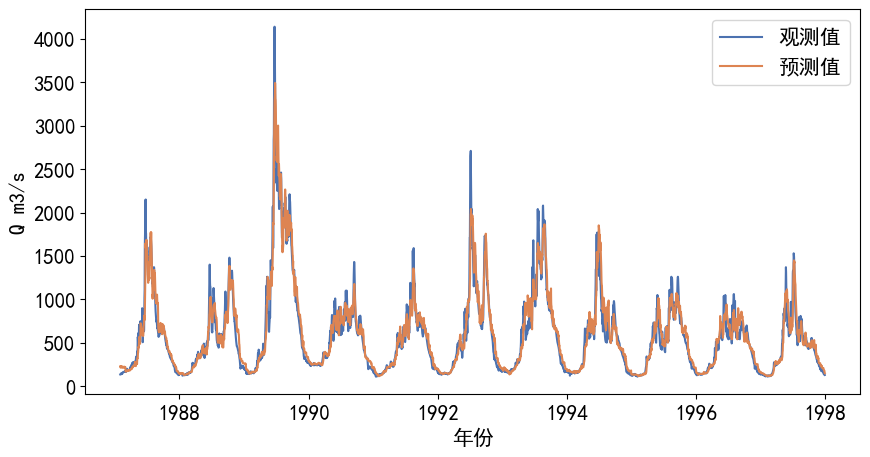

In [7]:
data = pd.read_excel(r'E:\work\data-stream\模型预测结果\mean_prediction\prediction_stream.xlsx')
#添加时间索引
data.index = pd.date_range('1987-01-31','1997-12-30')
# print(data)
#按索引取值
# data = data.loc['1997-05-30':'1997-07-30']
nse = 1 - np.sum((data['OBSERVED']-data['stream-30'])**2)/np.sum((data['OBSERVED']-np.mean(data['OBSERVED']))**2)
print('nse=',nse)
#绘图
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("deep")

#正常显示中文

# data.plot()

#字体设置大小
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = ['SimHei']    
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
plt.plot(data.index,data['OBSERVED'])
plt.plot(data.index,data['stream-30'])
#横坐标按年份显示
# plt.plot(data.index,data['obs'],linewidth=0.1)
# plt.plot(data.index,data['stream_mean'],linewidth=0.1)
# plt.xlabel('year')
# plt.ylabel('Q m3/s')
plt.legend(['观测值','预测值'],loc='upper right')
plt.xlabel('年份')
plt.ylabel('Q m3/s')
# plt.legend(loc='upper right')


# plt.savefig(r'e:\work\data-stream\revision\stream_prediction2.png',dpi=500)
plt.savefig(r'e:\work\毕设\图表\3-12a.png',dpi=500)
plt.show()

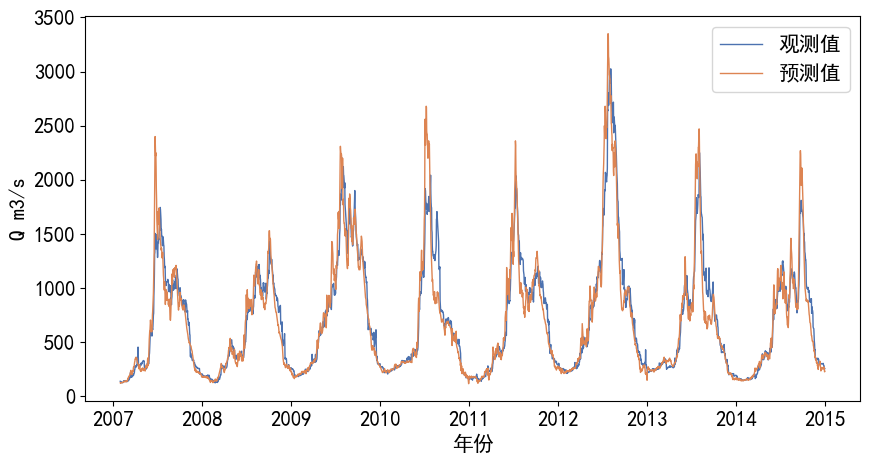

0.9140644042230781 70.96333146233587 0.953286898348819 0.0 0.005388672283407776


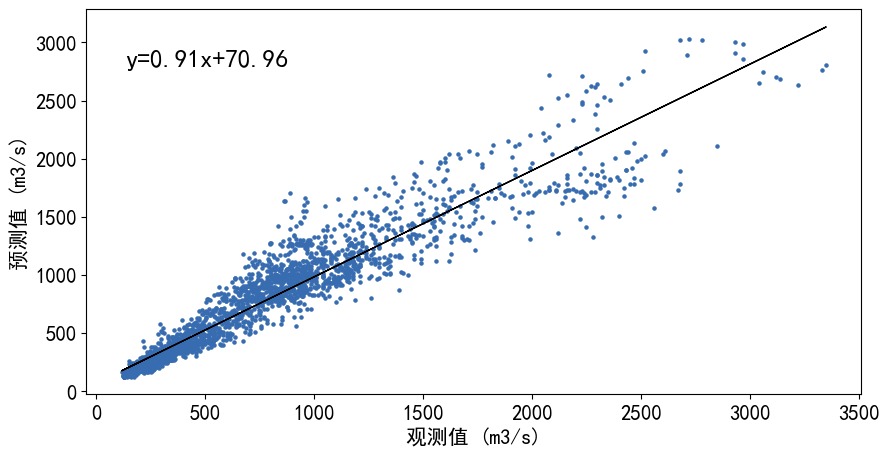

In [39]:
#引入stats模块
from scipy import stats

data = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\1987_2014_stream_3_mean.xlsx')
pred = data['pred'][3987:]
obs = data['obs'][3987:]
index = pd.date_range('2007-01-31','2014-12-30')
#变为dataframe
pred = pd.DataFrame(pred)
obs = pd.DataFrame(obs)
#对应时间索引
pred.index = index
obs.index = index

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("deep")
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = ['SimHei']    
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
plt.plot(pred)
plt.plot(obs)
plt.legend(['观测值','预测值'],loc='upper right')
plt.xlabel('年份')
plt.ylabel('Q m3/s')
# plt.legend(loc='upper right')
plt.savefig(r'e:\work\毕设\图表\3-17a.png',dpi=500)
plt.show()

#绘制散点图 
obs = np.array(obs).reshape(-1)
pred = np.array(pred).reshape(-1)
plt.figure(figsize=(10,5))
plt.scatter(obs,pred,marker='o',color=plt.get_cmap('Accent')(4),s=5)
plt.xlabel('观测值 (m3/s)')
plt.ylabel('预测值 (m3/s)')
slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
print(slope, intercept, r_value, p_value, std_err)
plt.rcParams['lines.linewidth'] = 1
plt.plot(obs,slope*obs+intercept,color='black')
plt.text(0.05,0.85,'y=0.91x+70.96',transform=plt.gca().transAxes,fontsize=18)
plt.savefig(r'e:\work\毕设\图表\3-17b.png',dpi=300)
plt.show()

0.9450280777508175 68.40174102704441 0.93861325461178 0.0 0.005502078210759168


C:\Users\FeichiHu\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35266 (\N{CJK UNIFIED IDEOGRAPH-89C2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\FeichiHu\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\FeichiHu\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\FeichiHu\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


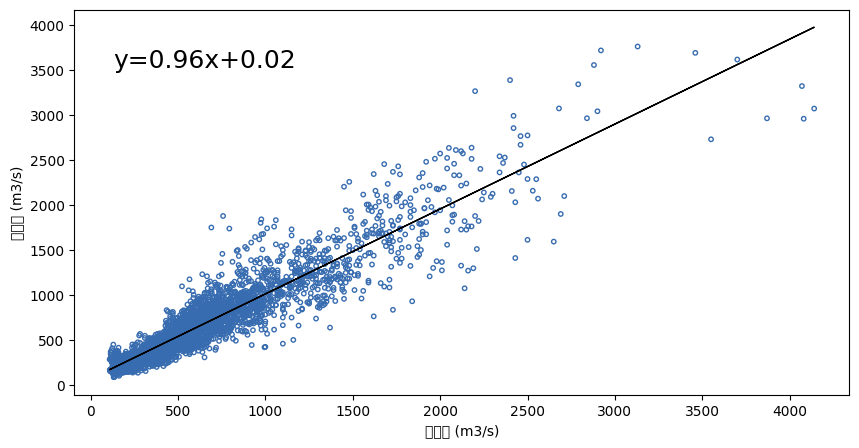

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

data = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\stream.xlsx')
data = np.array(data)
obs = np.array(data[:,1],dtype='float32')
pred = np.array(data[:,2],dtype='float32')
#绘制折线图
# plt.figure(figsize=(10,5))
# plt.plot(obs,linewidth=0.5)
# plt.plot(pred,linewidth=0.5)
# plt.xlabel('year')
# plt.ylabel('Q m3/s')
# #设置legend
# plt.legend(['observation','prediction'],loc='upper right')
# # plt.savefig(r'e:\work\data-stream\revision\stream_prediction.png',dpi=300)
# plt.show()

#绘制散点图 
plt.figure(figsize=(10,5))
#空心圆散点图
# plt.scatter(obs,pred,marker='o',color=plt.get_cmap('Accent')(4),s=5)
plt.scatter(obs,pred,c='none',marker='o',edgecolors=plt.get_cmap('Accent')(4),s=10)
# plt.scatter(obs,pred,marker='o',color='black',s=5)
# plt.xlabel('observation (m3/s)')
# plt.ylabel('prediction (m3/s)')
plt.xlabel('观测值 (m3/s)')
plt.ylabel('预测值 (m3/s)')
#绘制回归线
slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
print(slope, intercept, r_value, p_value, std_err)
#设置线宽
plt.rcParams['lines.linewidth'] = 1
plt.plot(obs,slope*obs+intercept,color='black')
#标注回归方程
plt.text(0.05,0.85,'y=0.96x+0.02',transform=plt.gca().transAxes,fontsize=18)
# plt.savefig(r'e:\work\data-stream\revision\scatter.png',dpi=300)
# plt.savefig(r'e:\work\毕设\图表\3-12b.png',dpi=300)

plt.show()


-26.331168831168757 5183.271428571428 -0.38351776027741946 0.08612187770729224 14.546566973621607
-3.055560258454038 201.71676459702695 -0.40577668203289463 0.06798979451185859 1.5789194633391925


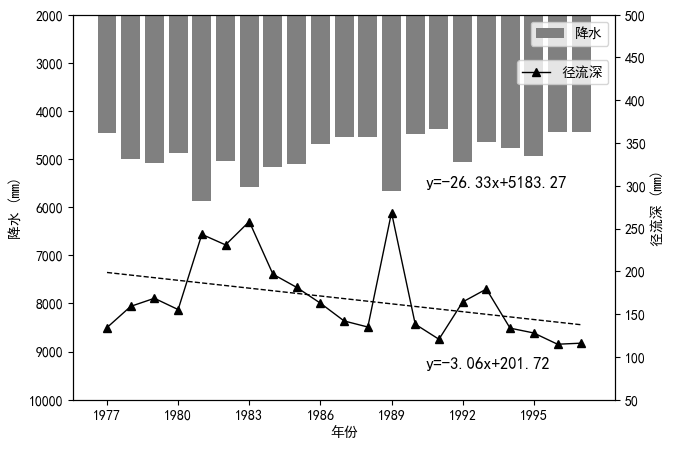

In [5]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats



def calculate_runoff_depth(flow_rate, area_km2=121972):
    """
    计算径流深度

    参数:
    flow_rate: 每日平均流速（立方米/秒）
    area_km2: 流域面积（平方公里）

    返回:
    日均径流深（毫米）
    """
    # 将面积从平方公里转换为平方米
    area_m2 = area_km2 * 1e6

    # 计算一天内流经该区域的总水体积（立方米）
    total_volume = flow_rate * 86400  # 一天有86400秒

    # 计算径流深（米），然后转换为毫米
    runoff_depth_mm = (total_volume / area_m2) * 1000

    return runoff_depth_mm


data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997_PQ.xlsx',sheet_name='Year')
data.index = data['year']
P = data['accP']
T = data['avgT']
E = data['accE']
Q = data['accQ']
Q = calculate_runoff_depth(Q)
years = range(1977, 1998)  # 这应该是你的年份数据
xlim = range(1,22)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.figure(figsize=(7,5))
#将P与Q在同一图中绘制，分两个y轴
ax1 = plt.subplot(111)
# ax1.bar(xlim,P,color='grey',label='P')
ax1.bar(xlim,P,color='grey',label='降水')
plt.legend(loc='upper right')
# ax1.set_ylabel('P (mm)')
ax1.set_ylabel('降水 (mm)')
ax1.set_ylim(2000,10000)
# ax1.set_xlabel('year')
ax1.set_xlabel('年份')
ax1.invert_yaxis() 
#绘制回归线
slope, intercept, r_value, p_value, std_err = stats.linregress(xlim,P)
print(slope, intercept, r_value, p_value, std_err)
#设置线宽
plt.rcParams['lines.linewidth'] = 1
# plt.plot(xlim,slope*xlim+intercept,color='black',linewidth=1,linestyle='--')
#标注回归方程
plt.text(0.65,0.55,'y=-26.33x+5183.27',transform=plt.gca().transAxes,fontsize=12)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # 保留整数

ax2 = ax1.twinx()
# ax2.plot(xlim,Q,color='black',label='runoff depth',marker='^')
ax2.plot(xlim,Q,color='black',label='径流深',marker='^')
# ax2.set_ylabel('runoff depth (mm)')
ax2.set_ylabel('径流深 (mm)')
ax2.set_ylim(50,500)
plt.legend(loc='upper right')
#legend下移
plt.legend(bbox_to_anchor=(1,0.9))
slope, intercept, r_value, p_value, std_err = stats.linregress(xlim,Q)
print(slope, intercept, r_value, p_value, std_err)
#设置线宽
plt.rcParams['lines.linewidth'] = 1
plt.plot(xlim,slope*xlim+intercept,color='black',linewidth=1,linestyle='--')
#标注回归方程
plt.text(0.65,0.08,'y=-3.06x+201.72',transform=plt.gca().transAxes,fontsize=12)

#x轴显示为年份
plt.xticks(xlim,years)
#x轴从第一个开始，每5个值对应一个标签
plt.xticks(np.arange(1, 22, 3))



# plt.savefig(r'e:\work\data-stream\revision\P_rd.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\2-2.png',dpi=300)
plt.show()

-0.2699346320346549 744.6523138321998 -0.03824573926357975 0.8692654289370405 1.618008821227139
0.011717561267611785 -0.28978838370066173 0.16491817195304695 0.4749874328942264 0.016076967986254884


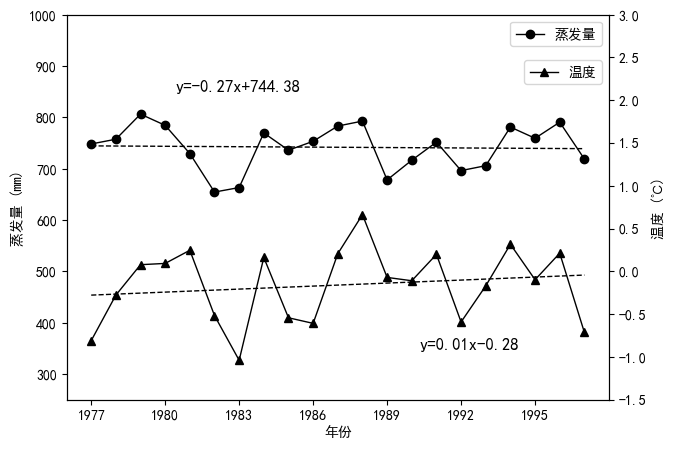

In [4]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats



def calculate_runoff_depth(flow_rate, area_km2=121972):
    """
    计算径流深度

    参数:
    flow_rate: 每日平均流速（立方米/秒）
    area_km2: 流域面积（平方公里）

    返回:
    日均径流深（毫米）
    """
    # 将面积从平方公里转换为平方米
    area_m2 = area_km2 * 1e6

    # 计算一天内流经该区域的总水体积（立方米）
    total_volume = flow_rate * 86400  # 一天有86400秒

    # 计算径流深（米），然后转换为毫米
    runoff_depth_mm = (total_volume / area_m2) * 1000

    return runoff_depth_mm


data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997_PQ.xlsx',sheet_name='Year')
data.index = data['year']
P = data['accP']
T = data['avgT']
E = data['accE']
Q = data['accQ']
Q = calculate_runoff_depth(Q)
years = range(1977, 1998)
xlim = range(1,22)
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.figure(figsize=(7,5))
ax1 = plt.subplot(111)
ax1.plot(xlim,E,color='black',label='蒸发量',marker='o')
plt.legend(loc='upper right')
ax1.set_ylabel('蒸发量 (mm)')
ax1.set_ylim(250,1000)
# ax1.set_xlabel('year')
ax1.set_xlabel('年份')

slope, intercept, r_value, p_value, std_err = stats.linregress(xlim,E)
print(slope, intercept, r_value, p_value, std_err)
plt.rcParams['lines.linewidth'] = 1
plt.plot(xlim,slope*xlim+intercept,color='black',linewidth=1,linestyle='--')
plt.text(0.20,0.80,'y=-0.27x+744.38',transform=plt.gca().transAxes,fontsize=12)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  

ax2 = ax1.twinx()
ax2.plot(xlim,T,color='black',label='温度',marker='^')
# ax2.set_ylabel('runoff depth (mm)')
ax2.set_ylabel('温度 (℃)')
ax2.set_ylim(-1.5,3)
plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1,0.9))
slope, intercept, r_value, p_value, std_err = stats.linregress(xlim,T)
print(slope, intercept, r_value, p_value, std_err)
plt.rcParams['lines.linewidth'] = 1
plt.plot(xlim,slope*xlim+intercept,color='black',linewidth=1,linestyle='--')
plt.text(0.65,0.13,'y=0.01x-0.28',transform=plt.gca().transAxes,fontsize=12)

plt.xticks(xlim,years)
plt.xticks(np.arange(1, 22, 3))

#坐标轴负号显示
plt.rcParams['axes.unicode_minus'] = False


# plt.savefig(r'e:\work\data-stream\revision\P_rd.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\2-3.png',dpi=300)
plt.show()

C:\Users\FeichiHu\AppData\Local\Temp\ipykernel_9912\1404436131.py:92: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(date,uf,'r',label='UFk',linewidth =2.0,color='black')
C:\Users\FeichiHu\AppData\Local\Temp\ipykernel_9912\1404436131.py:93: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(date,ub,'b',label='UBk',linewidth =2.0,color='black',linestyle='--')


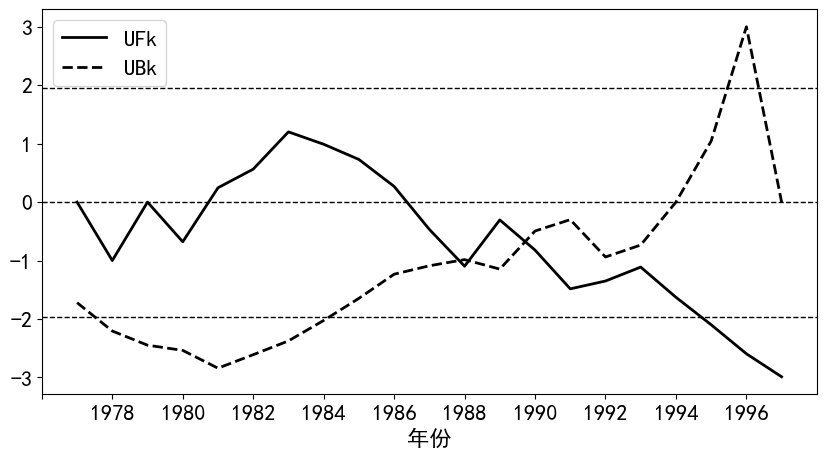

In [35]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats



def calculate_runoff_depth(flow_rate, area_km2=121972):
    """
    计算径流深度

    参数:
    flow_rate: 每日平均流速（立方米/秒）
    area_km2: 流域面积（平方公里）

    返回:
    日均径流深（毫米）
    """
    # 将面积从平方公里转换为平方米
    area_m2 = area_km2 * 1e6

    # 计算一天内流经该区域的总水体积（立方米）
    total_volume = flow_rate * 86400  # 一天有86400秒

    # 计算径流深（米），然后转换为毫米
    runoff_depth_mm = (total_volume / area_m2) * 1000

    return runoff_depth_mm

def mktest(inputdata):
    inputdata = np.array(inputdata)
    n=inputdata.shape[0]
    Sk = [0]
    UFk = [0]
    s = 0
    Exp_value = [0]
    Var_value = [0]
    for i in range(1,n):
        for j in range(i):
            if inputdata[i] > inputdata[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        Exp_value.append((i+1)*(i+2)/4 )
        Var_value.append((i+1)*i*(2*(i+1)+5)/72 )
        UFk.append((Sk[i]-Exp_value[i])/np.sqrt(Var_value[i]))
    Sk2 = [0]
    UBk = [0]
    UBk2 = [0]
    s2 = 0
    Exp_value2 = [0]
    Var_value2 = [0]
    inputdataT = list(reversed(inputdata))
    for i in range(1,n):
        for j in range(i):
            if inputdataT[i] > inputdataT[j]:
                s2 = s2+1
            else:
                s2 = s2+0
        Sk2.append(s2)
        Exp_value2.append((i+1)*(i+2)/4 )
        Var_value2.append((i+1)*i*(2*(i+1)+5)/72 )
        UBk.append((Sk2[i]-Exp_value2[i])/np.sqrt(Var_value2[i]))
        UBk2.append(-UBk[i])
    UBkT = list(reversed(UBk2))
    return UFk, UBkT

#设置字号大小
plt.rcParams['font.size'] = 16
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997_PQ.xlsx',sheet_name='Year')
Q = data['accQ']
# Q = calculate_runoff_depth(Q)
# date = pd.date_range('1977-01-31','1997-12-30')
# data.index = data['year']
# years = range(1977, 1998)
# xlim = range(1,22)
date = range(1,22)

uf,ub = mktest(Q)
plt.figure(figsize=(10,5))
# plt.title('Mann-Kendall test')
# plt.axhline(1.96,label = '0.05 level of significance',linestyle='--',color = 'black')
plt.axhline(1.96,linestyle='--',color = 'black')
plt.axhline(-1.96,linestyle='--',color = 'black')
plt.axhline(0,linestyle='--',color = 'black')
#plt.axvline(3536,linestyle='--',color = 'g',label = 'mutation')
plt.plot(date,uf,'r',label='UFk',linewidth =2.0,color='black')
plt.plot(date,ub,'b',label='UBk',linewidth =2.0,color='black',linestyle='--')
# plt.plot(uf,'r',label='UFk')
# plt.plot(ub,'b',label='UBk')
# plt.xlabel('Time')
plt.xlabel('年份')
plt.xticks(date,range(1977,1998))

# plt.ylabel('Statistics')
plt.xticks(range(0,21,2))
# plt.xticks(rotation = 0)
plt.legend()
# plt.savefig(r'e:\work\data-stream\revision\P_rd.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\2-4.png',dpi=300)
plt.show()

nse_1: 0.7010383337120951 lenth_1: 101
nse_3: 0.8730233202250606 lenth_3: 111
nse_4: 0.7501395760711699 lenth_4: 139
nse_5: 0.7607035164614041 lenth_5: 104
nse_6: 0.7326048046128053 lenth_6: 118
nse_7: 0.7258543684060725 lenth_7: 128
nse_8: 0.7242910810691545 lenth_8: 118
nse_9: 0.7381302641697254 lenth_9: 108
nse_10: 0.5575285930972244 lenth_10: 63
nse_11: 0.6847090040952151 lenth_11: 123


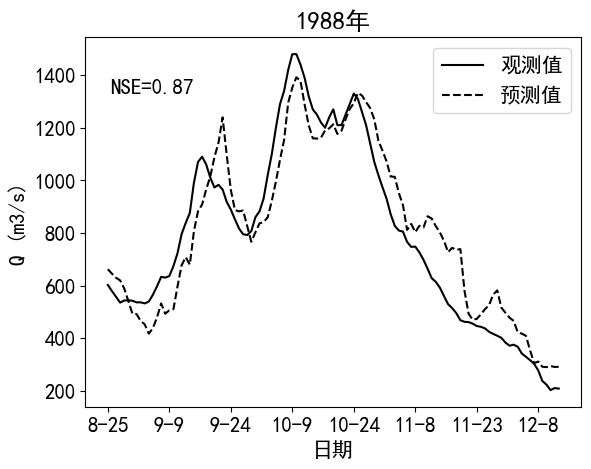

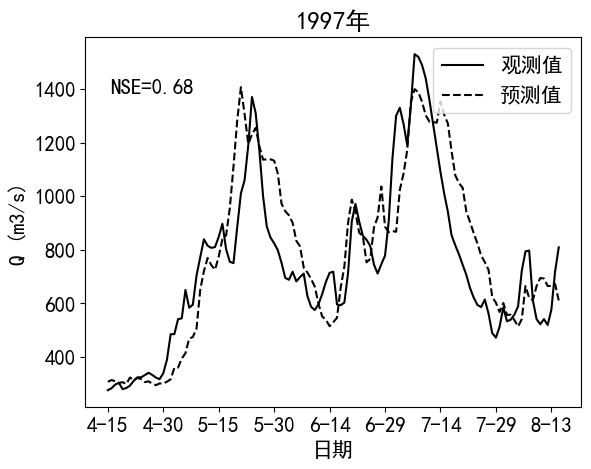

In [2]:
data_1 = pd.read_excel(r'E:\work\data-stream\模型预测结果\mean_prediction\prediction_stream.xlsx')
data_2 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\stream.xlsx')
data_1.index = pd.date_range('1987-01-31','1997-12-30')
data_2.index = pd.date_range('1987-01-31','1997-12-30')
#取出需要的数据
time = data_1.index
obs = data_1['OBSERVED']

#取两个dataframe的stream-30列
data_1 = data_1['stream-30']
data_2 = data_2['stream-30']
mean = (data_1+data_2)/2
#形成一个新的dataframe
data = pd.DataFrame({'OBSERVED':obs,'stream-30':mean})


#添加时间索引
data.index = pd.date_range('1987-01-31','1997-12-30')
# obs = data['OBSERVED']
# pred = data['stream-30']
# time_period_1 = data.loc['1987-06-20':'1987-08-13']
# time_period_2 = data.loc['1988-06-19':'1988-06-23']
# time_period_3 = data.loc['1988-10-06':'1988-10-28']
# time_period_4 = data.loc['1989-05-31':'1989-10-16']
# time_period_5 = data.loc['1990-09-14':'1990-09-20']
# time_period_6 = data.loc['1991-07-31':'1991-08-24']
# time_period_7 = data.loc['1992-06-29':'1992-10-06']
# time_period_8 = data.loc['1993-07-14':'1993-09-8']
# time_period_9 = data.loc['1994-06-14':'1994-07-12']
# time_period_10 = data.loc['1995-08-15':'1995-09-23']
# time_period_11 = data.loc['1997-05-24':'1997-07-13']

time_period_1 = data.loc['1987-06-05':'1987-09-13']
# time_period_2 = data.loc['1988-06-19':'1988-06-23']
# time_period_3 = data.loc['1988-09-25':'1988-11-13']
time_period_3 = data.loc['1988-08-25':'1988-12-13']
time_period_4 = data.loc['1989-05-31':'1989-10-16']
time_period_5 = data.loc['1990-07-30':'1990-11-10']
time_period_6 = data.loc['1991-06-15':'1991-10-10']
time_period_7 = data.loc['1992-06-15':'1992-10-20']
time_period_8 = data.loc['1993-06-15':'1993-10-10']
time_period_9 = data.loc['1994-05-05':'1994-08-20']
time_period_10 = data.loc['1995-07-30':'1995-09-30']
time_period_11 = data.loc['1997-04-15':'1997-08-15']

lenth_1 = len(time_period_1)
# lenth_2 = len(time_period_2)
lenth_3 = len(time_period_3)
lenth_4 = len(time_period_4)
lenth_5 = len(time_period_5)
lenth_6 = len(time_period_6)
lenth_7 = len(time_period_7)
lenth_8 = len(time_period_8)
lenth_9 = len(time_period_9)
lenth_10 = len(time_period_10)
lenth_11 = len(time_period_11)

def calculate_nse(data):
    obs = data['OBSERVED']
    pred = data['stream-30']
    nse = 1 - np.sum((obs-pred)**2)/np.sum((obs-np.mean(obs))**2)
    return nse

nse_1 = calculate_nse(time_period_1)
# nse_2 = calculate_nse(time_period_2)
nse_3 = calculate_nse(time_period_3)
nse_4 = calculate_nse(time_period_4)
nse_5 = calculate_nse(time_period_5)
nse_6 = calculate_nse(time_period_6)
nse_7 = calculate_nse(time_period_7)
nse_8 = calculate_nse(time_period_8)
nse_9 = calculate_nse(time_period_9)
nse_10 = calculate_nse(time_period_10)
nse_11 = calculate_nse(time_period_11)
print('nse_1:',nse_1,'lenth_1:',lenth_1)
# print('nse_2:',nse_2,'lenth_2:',lenth_2)
print('nse_3:',nse_3,'lenth_3:',lenth_3)
print('nse_4:',nse_4,'lenth_4:',lenth_4)
print('nse_5:',nse_5,'lenth_5:',lenth_5)
print('nse_6:',nse_6,'lenth_6:',lenth_6)
print('nse_7:',nse_7,'lenth_7:',lenth_7)
print('nse_8:',nse_8,'lenth_8:',lenth_8)
print('nse_9:',nse_9,'lenth_9:',lenth_9)
print('nse_10:',nse_10,'lenth_10:',lenth_10)
print('nse_11:',nse_11,'lenth_11:',lenth_11)

#绘图
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure()
# plt.plot(time_period_1.index,time_period_1['OBSERVED'],label='observation')
# plt.plot(time_period_1.index,time_period_1['stream-30'],label='prediction')
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_1.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1987')
# plt.show()

plt.figure()
#设置字体
plt.rcParams['font.sans-serif']=['SimHei']
#字号
plt.rcParams['font.size'] = 15

plt.plot(time_period_3.index,time_period_3['OBSERVED'],label='观测值',color = 'black')
plt.plot(time_period_3.index,time_period_3['stream-30'],label='预测值',color = 'black',linestyle='--')
plt.xticks(time_period_3.index[::15])
ax = plt.gca()
date_format = mdates.DateFormatter('%b-%d')  # 月-日
ax.xaxis.set_major_formatter(date_format)
#横坐标用中文显示
plt.xticks(time_period_3.index[::15],['8-25','9-9','9-24','10-9','10-24','11-8','11-23','12-8'])
# plt.xticks(time_period_3.index[::15])
plt.legend(loc='upper right')
plt.title('1988年')
plt.xlabel('日期')
plt.ylabel('Q (m3/s)')
plt.text(0.05,0.85,'NSE=0.87',transform=plt.gca().transAxes,fontsize=15)
# plt.savefig(r'e:\work\data-stream\revision\peak_1988.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\3-16a.png',dpi=300)
plt.show()

# plt.figure()
# plt.plot(time_period_4.index,time_period_4['OBSERVED'],label='observation')
# plt.plot(time_period_4.index,time_period_4['stream-30'],label='prediction')
# plt.xticks(time_period_4.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_4.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1989')
# plt.show()

# plt.figure()
# plt.plot(time_period_5.index,time_period_5['OBSERVED'],label='observation')
# plt.plot(time_period_5.index,time_period_5['stream-30'],label='prediction')
# plt.xticks(time_period_5.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_5.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1990')
# plt.show()

# plt.figure()
# plt.plot(time_period_6.index,time_period_6['OBSERVED'],label='observation')
# plt.plot(time_period_6.index,time_period_6['stream-30'],label='prediction')
# plt.xticks(time_period_6.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_6.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1991')
# plt.show()

# plt.figure()
# plt.plot(time_period_7.index,time_period_7['OBSERVED'],label='observation')
# plt.plot(time_period_7.index,time_period_7['stream-30'],label='prediction')
# plt.xticks(time_period_7.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_7.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1992')
# plt.show()

# plt.figure()
# plt.plot(time_period_8.index,time_period_8['OBSERVED'],label='observation')
# plt.plot(time_period_8.index,time_period_8['stream-30'],label='prediction')
# plt.xticks(time_period_8.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_8.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1993')
# plt.show()

# plt.figure()
# plt.plot(time_period_9.index,time_period_9['OBSERVED'],label='observation')
# plt.plot(time_period_9.index,time_period_9['stream-30'],label='prediction')
# plt.xticks(time_period_9.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_9.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1994')
# plt.show()

# plt.figure()
# plt.plot(time_period_10.index,time_period_10['OBSERVED'],label='observation')
# plt.plot(time_period_10.index,time_period_10['stream-30'],label='prediction')
# plt.xticks(time_period_10.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_10.index[::15])
# plt.legend(loc='upper right')
# plt.xlabel('Date in 1995')
# plt.show()

plt.figure()
# plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.size'] = 15
plt.plot(time_period_11.index,time_period_11['OBSERVED'],label='观测值',color = 'black')
plt.plot(time_period_11.index,time_period_11['stream-30'],label='预测值',color = 'black',linestyle='--')
plt.xticks(time_period_11.index[::15])
ax = plt.gca()
date_format = mdates.DateFormatter('%b-%d')  # 月-日
ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_11.index[::15])
plt.xticks(time_period_11.index[::15],['4-15','4-30','5-15','5-30','6-14','6-29','7-14','7-29','8-13'])
plt.legend(loc='upper right')
plt.title('1997年')
# plt.xlabel('Date in 1997')
plt.xlabel('日期')
plt.ylabel('Q (m3/s)')
plt.text(0.05,0.85,'NSE=0.68',transform=plt.gca().transAxes,fontsize=15)
# plt.savefig(r'e:\work\data-stream\revision\peak_1997.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\3-16b.png',dpi=300)
plt.show()





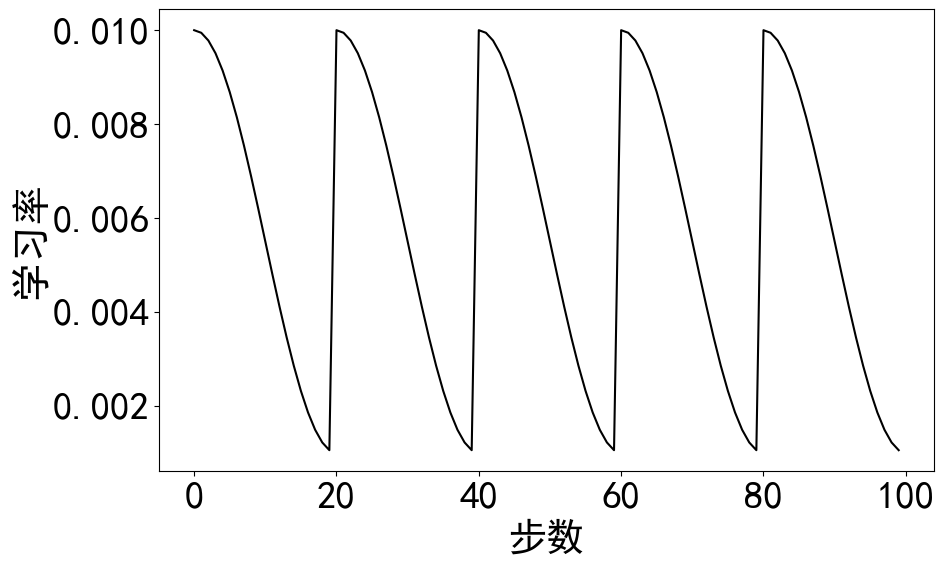

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 定义余弦退火衰减函数
def cosine_annealing(step, total_steps, initial_lr=0.01, min_lr=0.001):
    cos = np.cos(np.pi * step / total_steps) + 1
    decay = 0.5 * cos
    lr = min_lr + (initial_lr - min_lr) * decay
    return lr

# 创建步骤数组
steps = np.arange(0, 100)

# 计算每一步的学习率
learning_rates = [cosine_annealing(step, 100) for step in steps]

# 定义周期性衰减函数
def cyclical_annealing(step, cycle_length=20, initial_lr=0.01, min_lr=0.001):
    cycle_progress = step % cycle_length
    return cosine_annealing(cycle_progress, cycle_length, initial_lr, min_lr)

# 计算每一步的学习率
cyclical_learning_rates = [cyclical_annealing(step, 20) for step in steps]

#中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
#字体
plt.rcParams['font.size'] = 28
# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(steps, cyclical_learning_rates,color='black')
# plt.title("Cyclical Annealing Decay")
# plt.xlabel("Step")
plt.xlabel("步数")
# plt.ylabel("Learning Rate")
plt.ylabel("学习率")
# plt.grid(True)
plt.savefig(r'e:\work\毕设\图表\3-11.png',dpi=300)
plt.show()

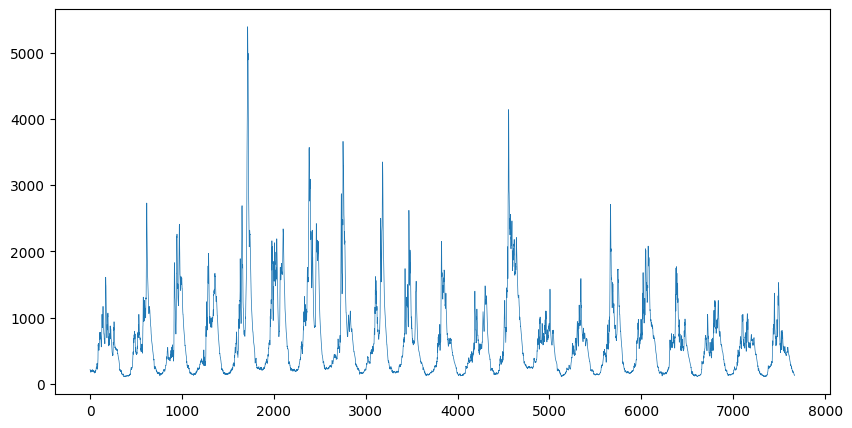

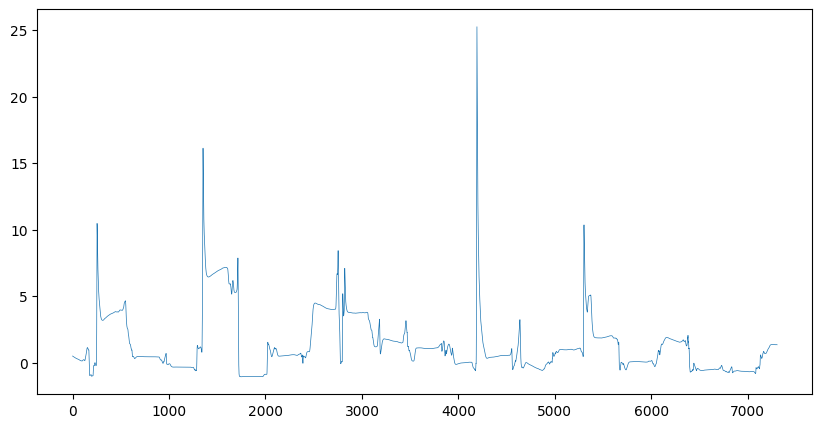

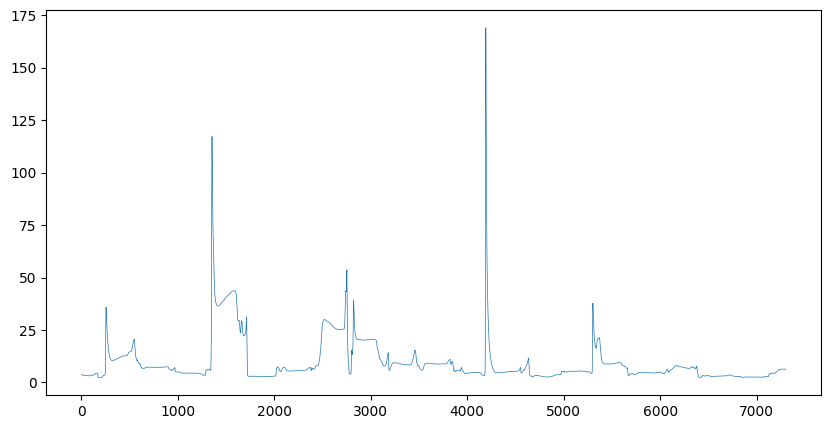

In [46]:
import pywt

def sliding_window(data, sw_width, in_start=0):
    #该函数实现窗口宽度为sw_width、滑动步长为1的滑动窗口截取序列数据
    X = []
    data = np.array(data, type(float))
    for _ in range(data.shape[0]):
        in_end = in_start + sw_width
        if (in_end>data.shape[0]):
            break
        else:
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        # 训练数据以滑动步长1截取
            train_seq = data[in_start:in_end]
            X.append(train_seq)
            in_start += 1
    return np.array(X)

# 计算峰度和偏度
def kurt_skew(data):
    kurt = []
    skew = []
    for i in range(data.shape[0]):
        kurt.append(pd.Series(data[i,:]).kurt())
        skew.append(pd.Series(data[i,:]).skew())
    return kurt, skew

data = pd.read_excel(r'E:\work\Basin\Tangnaihai\1977-1997\1977-1997_PQ.xlsx')
data = np.array(data)
maduo = data[:,3]
dari = data[:,4]
guoluo = data[:,5]
xinghai = data[:,6]
ruoergai = data[:,7]
jiuzhi = data[:,8]
henan = data[:,9]
hongyuan = data[:,10]
runoff = data[:,11]

plt.figure(figsize=(10,5))
plt.plot(runoff,linewidth=0.5)
plt.show()

# maduo = sliding_window(maduo, 30)
# dari = sliding_window(dari, 30)
# guoluo = sliding_window(guoluo, 30)
# xinghai = sliding_window(xinghai, 30)
# ruoergai = sliding_window(ruoergai, 30)
# jiuzhi = sliding_window(jiuzhi, 30)
# henan = sliding_window(henan, 30)
# hongyuan = sliding_window(hongyuan, 30)
runoff = sliding_window(runoff, 365)

# maduo_kurt, maduo_skew = kurt_skew(maduo)
# dari_kurt, dari_skew = kurt_skew(dari)
# guoluo_kurt, guoluo_skew = kurt_skew(guoluo)
# xinghai_kurt, xinghai_skew = kurt_skew(xinghai)
# ruoergai_kurt, ruoergai_skew = kurt_skew(ruoergai)
# jiuzhi_kurt, jiuzhi_skew = kurt_skew(jiuzhi)
# henan_kurt, henan_skew = kurt_skew(henan)
# hongyuan_kurt, hongyuan_skew = kurt_skew(hongyuan)
runoff_kurt, runoff_skew = kurt_skew(runoff)

#tanh函数
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
#sigmoid函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
#SoftExponential
def softexponential(x, alpha):
    if alpha < 0:
        return (-np.log(1 - alpha * (x + alpha))) / alpha
    elif alpha == 0:
        return x
    else:
        return (np.exp(alpha * x) - 1) / alpha + alpha


plt.figure(figsize=(10,5))
# maduo_kurt = tanh(np.array(maduo_kurt))
# maduo_skew = tanh(np.array(maduo_skew))
# maduo_kurt = sigmoid(np.array(maduo_kurt))
# maduo_skew = sigmoid(np.array(maduo_skew))
# maduo_kurt = softexponential(np.array(maduo_kurt),0.1)
# maduo_skew = softexponential(np.array(maduo_skew),2)
# runoff_kurt = tanh(np.array(runoff_kurt))
# runoff_skew = tanh(np.array(runoff_skew))   
# runoff_kurt = sigmoid(np.array(runoff_kurt))
# runoff_skew = sigmoid(np.array(runoff_skew))
runoff_kurt = softexponential(np.array(runoff_kurt),0.1)
runoff_skew = softexponential(np.array(runoff_skew),2)

plt.plot(runoff_kurt,linewidth=0.5)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(runoff_skew,linewidth=0.5)
plt.show()

# #定义计算z-score函数
# def z_score(data):
#     mean = np.mean(data)
#     std = np.std(data)
#     z = (data - mean)/std
#     return z
# #计算z-score
# maduo_z = z_score(maduo)
# dari_z = z_score(dari)
# guoluo_z = z_score(guoluo)
# xinghai_z = z_score(xinghai)
# ruoergai_z = z_score(ruoergai)
# jiuzhi_z = z_score(jiuzhi)
# henan_z = z_score(henan)
# hongyuan_z = z_score(hongyuan)
# runoff_z = z_score(runoff)
# #绘图
# plt.figure(figsize=(10,5))
# plt.plot(maduo_z,linewidth=0.5)
# plt.plot(dari_z,linewidth=0.5)
# plt.plot(guoluo_z,linewidth=0.5)
# plt.plot(xinghai_z,linewidth=0.5)
# plt.plot(ruoergai_z,linewidth=0.5)
# plt.plot(jiuzhi_z,linewidth=0.5)
# plt.plot(henan_z,linewidth=0.5)
# plt.plot(hongyuan_z,linewidth=0.5)
# plt.legend(['maduo','dari','guoluo','xinghai','ruoergai','jiuzhi','henan','hongyuan'],loc='upper right')
# plt.show()

# #绘图
# plt.figure(figsize=(10,5))
# plt.plot(runoff_z,linewidth=0.5)
# plt.show()



In [2]:
data = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\stream.xlsx')
data = np.array(data)
# obs = np.array(data[:,1],dtype='float32')
# pred = np.array(data[:,2],dtype='float32')
# adjust_stream = np.array(data[:,3],dtype='float32')
# adjust_lstm = np.array(data[:,4],dtype='float32')
#计算nse
def calculate_nse(obs,pred):
    nse = 1 - np.sum((obs-pred)**2)/np.sum((obs-np.mean(obs))**2)
    return nse
# nse_stream = calculate_nse(obs,pred)
# print(nse_stream)
# nse_adjust_stream = calculate_nse(obs,adjust_stream)
# print(nse_adjust_stream)
# nse_adjust_lstm = calculate_nse(obs,adjust_lstm)
# print(nse_adjust_lstm)

obs = data[:,0]
lstm = data[:,1]
tank = data[:,2]
rf = data[:,3]
svr = data[:,4]
xgboost = data[:,5]
stream = data[:,6]
nse_lstm = calculate_nse(obs,lstm)
nse_tank = calculate_nse(obs,tank)
nse_rf = calculate_nse(obs,rf)
nse_svr = calculate_nse(obs,svr)
nse_xgboost = calculate_nse(obs,xgboost)
nse_stream = calculate_nse(obs,stream)
print(nse_lstm)
print(nse_tank)
print(nse_rf)
print(nse_svr)
print(nse_xgboost)
print(nse_stream)
ad_lstm = (obs+lstm)/2
ad_tank = (obs+tank)/2
ad_rf = (obs+rf)/2
ad_svr = (obs+svr)/2
ad_xgboost = (obs+xgboost)/2
ad_stream = (obs+stream)/2
nse_ad_lstm = calculate_nse(obs,ad_lstm)
nse_ad_tank = calculate_nse(obs,ad_tank)
nse_ad_rf = calculate_nse(obs,ad_rf)
nse_ad_svr = calculate_nse(obs,ad_svr)
nse_ad_xgboost = calculate_nse(obs,ad_xgboost)
nse_ad_stream = calculate_nse(obs,ad_stream)
print(nse_ad_lstm)
print(nse_ad_tank)
print(nse_ad_rf)
print(nse_ad_svr)
print(nse_ad_xgboost)
print(nse_ad_stream)

ad_mean = (0.5*ad_lstm+0.5*ad_tank+stream+0.5*ad_svr)/2.5
nse_ad_mean = calculate_nse(obs,ad_mean)
print(nse_ad_mean)

#保存数据
ad_mean = pd.DataFrame(ad_mean)
ad_mean.to_excel(r'e:\work\毕设\ad_mean.xlsx')
# threshold = data['OBSERVED'].quantile(0.9)
# peak_indices = data[data['OBSERVED'] > threshold].index
# data.loc[peak_indices].head()

# # Calculate adjustment factor for peak values based on the ratio of observed to predicted values
# adjustment_factors = data.loc[peak_indices, 'OBSERVED'] / data.loc[peak_indices, 'stream-30']
# adjustment_factor = adjustment_factors.mean()
# #仅在峰值处调整预测值
# data['adjusted_stream-30'] = data['stream-30']
# data.loc[peak_indices, 'adjusted_stream-30'] = data.loc[peak_indices, 'stream-30'] * adjustment_factor
# print(data)
# print(adjustment_factor)

# data = np.array(data)

# ad = ad_mean
# # for循环，每次循环取出一个时间段的数据
# for i in range(0,11):
#     #取出一个时间段的数据
#     # time_period = data[i*365:(i+1)*365,:]
#     # temp_obs = time_period[:,1]
#     # temp_pred = time_period[:,2]
#     # temp_adjusted_stream = time_period[:,3]
#     # temp_adjusted_lstm = time_period[:,4]
#     temp_ad = ad[i*365:(i+1)*365]
#     temp_obs = obs[i*365:(i+1)*365]
#     plt.figure(figsize=(10,5))
#     plt.plot(temp_obs,linewidth=0.5)
#     plt.plot(temp_ad,linewidth=0.5)
#     # plt.plot(temp_pred,linewidth=0.5)
#     # plt.plot(temp_adjusted_stream,linewidth=0.5)
#     # plt.plot(temp_adjusted_lstm,linewidth=0.5)
#     # plt.legend(['observation','prediction','adjusted prediction'],loc='upper right')
#     plt.title(str(i+1987))
#     plt.show()


IndexError: index 3 is out of bounds for axis 1 with size 3

C:\Users\FeichiHu\AppData\Local\Temp\ipykernel_19940\2727483349.py:13: RuntimeWarning: invalid value encountered in log
  return -np.log(1-alpha*(self.x+alpha))/alpha


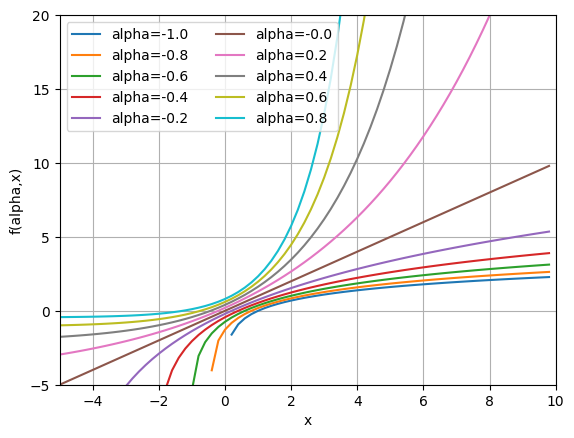

In [39]:
#绘制SoftExponential函数
import numpy as np
import matplotlib.pyplot as plt
import math

class soft_exponential:
	def __init__(self,alpha,x):
		self.alpha = alpha
		self.x = x

	def calculate(self,alpha):
		if alpha < 0:
			return -np.log(1-alpha*(self.x+alpha))/alpha
		elif alpha == 0:
			return self.x
		else:
			return ((np.exp(alpha*self.x)-1)/alpha) + alpha

	def function(self):
		result = []
		for i in self.alpha:
			sof_ex = self.calculate(i)
			result.append(sof_ex)
		self.plot_function(result)	
		return np.array(result)	

	def plot_function(self,output):
		for i in range(len(output)):
			plt.plot(self.x,output[i],label='alpha='+'{}'.format(self.alpha[i]))
		plt.xlim(-5,10)
		plt.ylim(-5,20)
		plt.xlabel('x')
		plt.ylabel("f(alpha,x)")
		plt.legend(loc='upper left',ncol=2)
		plt.grid(True)
		plt.savefig(r'e:\work\毕设\图表\4-3.png',dpi=300)
		plt.show()

if __name__ == '__main__':
	x = np.arange(-10,10,0.2)
	alpha = np.arange(-1,1,0.2)
	#alpha保留一位小数
	alpha = np.round(alpha,1)
	activation = soft_exponential(alpha,x)
	output = activation.function()

	

0.938021347135325 119.11064114918618 0.16985871997286747


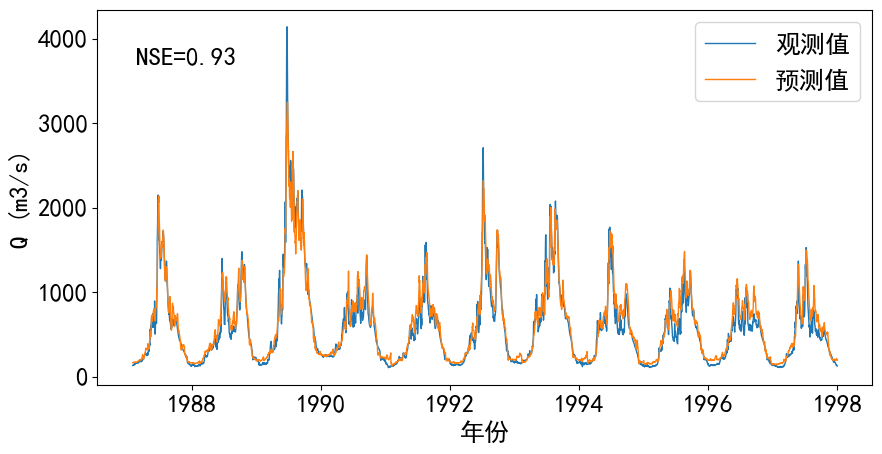

0.9436349878941599 77.81844622133235 0.9731065689439222 0.0 0.003538570444078069


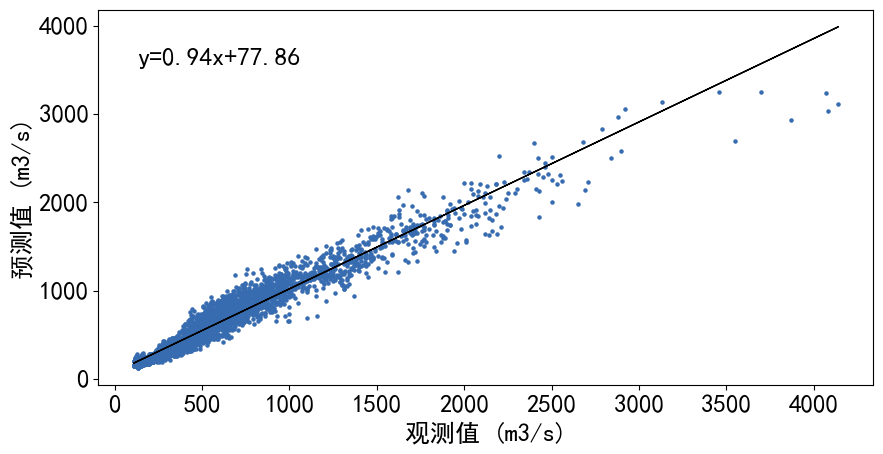

In [13]:
#计算nse
def calculate_nse(obs,pred):
    nse = 1 - np.sum((obs-pred)**2)/np.sum((obs-np.mean(obs))**2)
    return nse
#计算rmse
def calculate_rmse(obs,pred):
    rmse = np.sqrt(np.sum((obs-pred)**2)/len(obs))
    return rmse
#计算mape
def calculate_mape(obs,pred):
    mape = np.sum(np.abs(obs-pred)/obs)/len(obs)
    return mape
data = pd.read_excel(r'E:\work\毕设\ad_mean.xlsx')
#添加时间索引
data.index = pd.date_range('1987-02-01','1997-12-31')
obs = data['OBSERVED'] 
Astream = data['ad_mean']
stream = data['stream-30']

nse = calculate_nse(obs,Astream)
rmse = calculate_rmse(obs,Astream)
mape = calculate_mape(obs,Astream)
print(nse,rmse,mape)

#绘图
#显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
#字号
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10,5))
plt.plot(obs,linewidth=1)
plt.plot(Astream,linewidth=1)
# plt.plot(stream,linewidth=0.5)
plt.legend(['观测值','预测值'],loc='upper right')
plt.xlabel('年份')
plt.ylabel('Q (m3/s)')
plt.text(0.05,0.85,'NSE=0.93',transform=plt.gca().transAxes,fontsize=18)
#画布内边距调整
plt.subplots_adjust(top=0.9, bottom=0.15)
plt.savefig(r'e:\work\毕设\图表\4-3a.png',dpi=300)
plt.show()


#绘制散点图 
plt.figure(figsize=(10,5))
plt.scatter(obs,Astream,marker='o',color=plt.get_cmap('Accent')(4),s=5)
plt.xlabel('观测值 (m3/s)')
plt.ylabel('预测值 (m3/s)')
slope, intercept, r_value, p_value, std_err = stats.linregress(obs,Astream)
print(slope, intercept, r_value, p_value, std_err)
plt.rcParams['lines.linewidth'] = 1
plt.plot(obs,slope*obs+intercept,color='black')
plt.text(0.05,0.85,'y=0.94x+77.86',transform=plt.gca().transAxes,fontsize=18)
plt.subplots_adjust(top=0.9, bottom=0.15)
plt.savefig(r'e:\work\毕设\图表\4-3b.png',dpi=300)
plt.show()


0.8050625651050327 212.4314642713088 0.08532326341373536
0.45402067900191656 355.5161352769676 0.15848987708508527
0.7838135117937446 300.7727725468758 0.9086072156676376 7.351609714688847e-152 0.01812809846863636


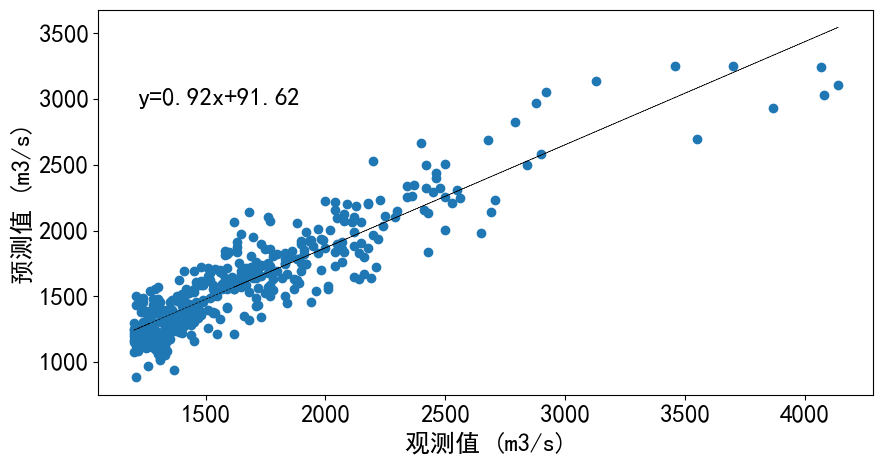

0.9159871436643997 91.62229070540229 0.7834718666441998 1.252636897570976e-83 0.03655592028501802


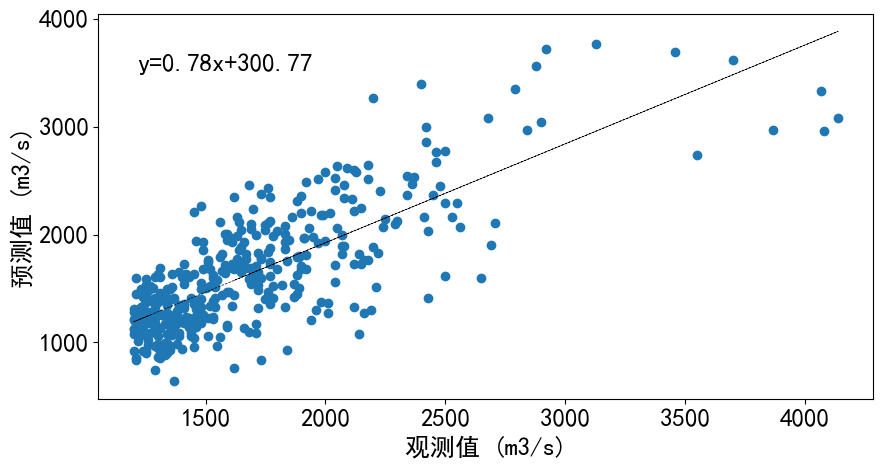

In [4]:
#计算nse
def calculate_nse(obs,pred):
    nse = 1 - np.sum((obs-pred)**2)/np.sum((obs-np.mean(obs))**2)
    return nse
#计算rmse
def calculate_rmse(obs,pred):
    rmse = np.sqrt(np.sum((obs-pred)**2)/len(obs))
    return rmse
#计算mape
def calculate_mape(obs,pred):
    mape = np.sum(np.abs(obs-pred)/obs)/len(obs)
    return mape
data = pd.read_excel(r'E:\work\毕设\ad_mean.xlsx')
#添加时间索引
data.index = pd.date_range('1987-02-01','1997-12-31')
obs = data['OBSERVED'] 
Astream = data['ad_mean']
stream = data['stream-30']
#查找obs中大于1190的索引
index_p = np.where(obs>1190)
#取出索引
#保证为dataframe
obs = pd.DataFrame(obs)
Astream = pd.DataFrame(Astream)
stream = pd.DataFrame(stream)
#取出索引
obs_peak = obs.iloc[index_p]
Astream_peak = Astream.iloc[index_p]
stream_peak = stream.iloc[index_p]

obs_peak = np.array(obs_peak)
Astream_peak = np.array(Astream_peak)
stream_peak = np.array(stream_peak)
#计算nse
nse_peak_a = calculate_nse(obs_peak,Astream_peak)
nse_peak_s = calculate_nse(obs_peak,stream_peak)
#计算rmse
rmse_peak_a = calculate_rmse(obs_peak,Astream_peak)
rmse_peak_s = calculate_rmse(obs_peak,stream_peak)
#计算mape
mape_peak_a = calculate_mape(obs_peak,Astream_peak)
mape_peak_s = calculate_mape(obs_peak,stream_peak)
print(nse_peak_a,rmse_peak_a,mape_peak_a)
print(nse_peak_s,rmse_peak_s,mape_peak_s)
#压缩数据为一维数组
obs_peak = obs_peak.flatten()
Astream_peak = Astream_peak.flatten()
stream_peak = stream_peak.flatten()

#绘制散点图
plt.figure(figsize=(10,5))
#字体
plt.rcParams['font.sans-serif'] = ['SimHei']
#字号
plt.rcParams['font.size'] = 18
plt.scatter(obs_peak,Astream_peak,marker='o')
# plt.scatter(obs_peak,stream_peak,marker='o',color = 'grey',s=5)
plt.xlabel('观测值 (m3/s)')
plt.ylabel('预测值 (m3/s)')
slope, intercept, r_value, p_value, std_err = stats.linregress(obs_peak,Astream_peak)
print(slope, intercept, r_value, p_value, std_err)
plt.rcParams['lines.linewidth'] = 1
plt.plot(obs_peak,slope*obs_peak+intercept,color='black',linestyle='--',linewidth=0.5)
plt.text(0.05,0.75,'y=0.92x+91.62',transform=plt.gca().transAxes,fontsize=18)
# plt.legend(['预测值','调整预测值'],loc='upper right')
plt.savefig(r'e:\work\毕设\图表\4-5.png',dpi=300)
plt.show()

plt.figure(figsize=(10,5))
# plt.scatter(obs_peak,Astream_peak,marker='o',color = 'black',s=5)
plt.scatter(obs_peak,stream_peak,marker='o')
plt.xlabel('观测值 (m3/s)')
plt.ylabel('预测值 (m3/s)')
slope, intercept, r_value, p_value, std_err = stats.linregress(obs_peak,stream_peak)
print(slope, intercept, r_value, p_value, std_err)
plt.rcParams['lines.linewidth'] = 1
plt.plot(obs_peak,slope*obs_peak+intercept,color='black',linestyle='--',linewidth=0.5)
plt.text(0.05,0.85,'y=0.78x+300.77',transform=plt.gca().transAxes,fontsize=18)
plt.savefig(r'e:\work\毕设\图表\4-6.png',dpi=300)
# plt.legend(['预测值','调整预测值'],loc='upper right')
plt.show()

0.9244460485348719
nse_1: 0.7335076505202085 lenth_1: 117
nse_3: 0.8730233202250606 lenth_3: 111
nse_4: 0.7501395760711699 lenth_4: 139
nse_5: 0.7899479326502972 lenth_5: 73
nse_6: 0.6918456337285006 lenth_6: 88
nse_7: 0.7258543684060725 lenth_7: 128
nse_8: 0.7242910810691545 lenth_8: 118
nse_9: 0.7381302641697254 lenth_9: 108
nse_10: 0.7580560275577616 lenth_10: 42
nse_11: 0.6847090040952151 lenth_11: 123


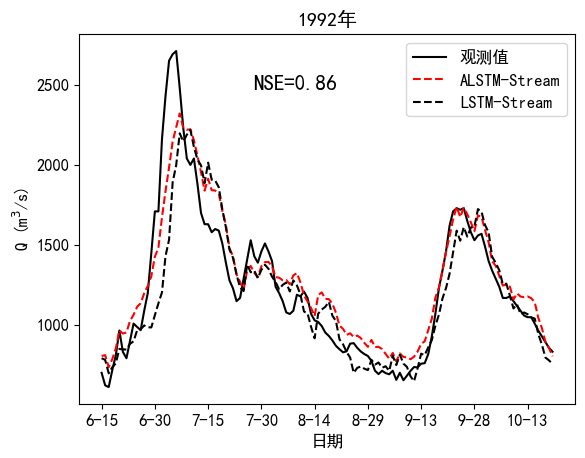

In [20]:
# ALSTM-STREAM
data = pd.read_excel(r'E:\work\毕设\ad_mean.xlsx')
time = data.index
obs = data['OBSERVED']
pred = data['ad_mean']
# data = pd.DataFrame({'OBSERVED':obs,'A-stream':pred})

#LSTM-STREAM
data_1 = pd.read_excel(r'E:\work\data-stream\模型预测结果\mean_prediction\prediction_stream.xlsx')
data_2 = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\stream.xlsx')
# obs = data_1['OBSERVED']
data_1 = data_1['stream-30']
data_2 = data_2['stream-30']
mean = (data_1+data_2)/2
# data = pd.DataFrame({'OBSERVED':obs,'stream':mean})
data = pd.DataFrame({'OBSERVED':obs,'A-stream':pred,'stream':mean})

#other models
# data = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\未校准\pred_lstm_87-97.xlsx')
# lstm = data['lstm']
# obs = data['obs']
# data = pd.DataFrame({'OBSERVED':obs,'lstm':lstm})
# data = pd.read_excel(r'E:\work\data-stream\模型预测结果\used data\未校准\tank_87-97.xlsx')
# obs = data['obs']
# tank = data['tank']
# data = pd.DataFrame({'OBSERVED':obs,'tank':tank})



#添加时间索引
data.index = pd.date_range('1987-01-31','1997-12-30')
time = data.index

time_period_1 = data.loc['1987-05-20':'1987-09-13']
time_period_3 = data.loc['1988-08-25':'1988-12-13']
time_period_4 = data.loc['1989-05-31':'1989-10-16']
time_period_5 = data.loc['1990-08-30':'1990-11-10']
time_period_6 = data.loc['1991-07-15':'1991-10-10']
time_period_7 = data.loc['1992-06-15':'1992-10-20']
time_period_8 = data.loc['1993-06-15':'1993-10-10']
time_period_9 = data.loc['1994-05-05':'1994-08-20']
time_period_10 = data.loc['1995-08-30':'1995-10-10']
time_period_11 = data.loc['1997-04-15':'1997-08-15']

lenth_1 = len(time_period_1)
# lenth_2 = len(time_period_2)
lenth_3 = len(time_period_3)
lenth_4 = len(time_period_4)
lenth_5 = len(time_period_5)
lenth_6 = len(time_period_6)
lenth_7 = len(time_period_7)
lenth_8 = len(time_period_8)
lenth_9 = len(time_period_9)
lenth_10 = len(time_period_10)
lenth_11 = len(time_period_11)

def calculate_nse(data):
    obs = data['OBSERVED']
    pred = data['stream']
    nse = 1 - np.sum((obs-pred)**2)/np.sum((obs-np.mean(obs))**2)
    return nse

#计算每个模型在不同时间段的NSE
nse = calculate_nse(data)
print(nse)
nse_1 = calculate_nse(time_period_1)
# nse_2 = calculate_nse(time_period_2)
nse_3 = calculate_nse(time_period_3)
nse_4 = calculate_nse(time_period_4)
nse_5 = calculate_nse(time_period_5)
nse_6 = calculate_nse(time_period_6)
nse_7 = calculate_nse(time_period_7)
nse_8 = calculate_nse(time_period_8)
nse_9 = calculate_nse(time_period_9)
nse_10 = calculate_nse(time_period_10)
nse_11 = calculate_nse(time_period_11)
print('nse_1:',nse_1,'lenth_1:',lenth_1)
# print('nse_2:',nse_2,'lenth_2:',lenth_2)
print('nse_3:',nse_3,'lenth_3:',lenth_3)
print('nse_4:',nse_4,'lenth_4:',lenth_4)
print('nse_5:',nse_5,'lenth_5:',lenth_5)
print('nse_6:',nse_6,'lenth_6:',lenth_6)
print('nse_7:',nse_7,'lenth_7:',lenth_7)
print('nse_8:',nse_8,'lenth_8:',lenth_8)
print('nse_9:',nse_9,'lenth_9:',lenth_9)
print('nse_10:',nse_10,'lenth_10:',lenth_10)
print('nse_11:',nse_11,'lenth_11:',lenth_11)

#绘图
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure()
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['font.size'] = 12

# plt.plot(time_period_3.index,time_period_3['OBSERVED'],label='观测值',color = 'black')
# plt.plot(time_period_3.index,time_period_3['A-stream'],label='ALSTM-Stream',color = 'red',linestyle='--')
# plt.plot(time_period_3.index,time_period_3['stream']-50,label='LSTM-Stream',color = 'black',linestyle='--')
# plt.xticks(time_period_3.index[::15])
# ax = plt.gca()
# date_format = mdates.DateFormatter('%b-%d')  # 月-日
# ax.xaxis.set_major_formatter(date_format)
# plt.xticks(time_period_3.index[::15],['8-25','9-9','9-24','10-9','10-24','11-8','11-23','12-8'])
# # plt.xticks(time_period_3.index[::15])
# plt.legend(loc='upper right')
# plt.title('1988年')
# plt.xlabel('日期')
# plt.ylabel('Q (m$^{3}$/s)')
# plt.text(0.05,0.85,'NSE=0.93',transform=plt.gca().transAxes,fontsize=15)
# # plt.savefig(r'e:\work\data-stream\revision\peak_1988.png',dpi=300)
# plt.savefig(r'e:\work\毕设\图表\4-7-1.png',dpi=300)
# plt.show()

plt.figure()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.size'] = 12

plt.plot(time_period_7.index,time_period_7['OBSERVED'],label='观测值',color = 'black')
plt.plot(time_period_7.index,time_period_7['A-stream'],label='ALSTM-Stream',color = 'red',linestyle='--')
plt.plot(time_period_7.index,time_period_7['stream']-50,label='LSTM-Stream',color = 'black',linestyle='--')
plt.xticks(time_period_7.index[::15])
ax = plt.gca()
date_format = mdates.DateFormatter('%b-%d')  # 月-日
ax.xaxis.set_major_formatter(date_format)
plt.xticks(time_period_7.index[::15],['6-15','6-30','7-15','7-30','8-14','8-29','9-13','9-28','10-13'])
# plt.xticks(time_period_3.index[::15])
plt.legend(loc='upper right')
plt.title('1992年')
plt.xlabel('日期')
plt.ylabel('Q (m$^{3}$/s)')
plt.text(0.35,0.85,'NSE=0.86',transform=plt.gca().transAxes,fontsize=15)
# plt.savefig(r'e:\work\data-stream\revision\peak_1988.png',dpi=300)
plt.savefig(r'e:\work\毕设\图表\4-7-2.png',dpi=300)
plt.show()

